<a href="https://colab.research.google.com/github/safikhanSoofiyani/CS6910-Assignment-3/blob/main/RNN_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import tensorflow as tf
import keras as ks
import random
import csv

from tensorflow.keras.layers import Dense, Input,InputLayer,Flatten,Activation,LSTM,SimpleRNN,GRU,TimeDistributed,Embedding
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate, AdditiveAttention

In [ ]:
random.seed(hash("seriously you compete with me") % 2**32 - 1)
np.random.seed(hash("i am mohammed safi") % 2**32 - 1)
tf.random.set_seed(hash("ur rahman khan") % 2**32 - 1)

In [ ]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
!nvidia-smi

Mon May  2 04:29:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    40W / 300W |    471MiB / 16160MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb
import wandb

from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 144 kB 64.2 MB/s 
     |████████████████████████████████| 181 kB 61.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4c73f68940f5555019689f504bc236fe0417dba01510c35e67c0ea2c286a0c70
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# English as source language and Telugu as target language
source_language='en'
target_language='te'

In [ ]:
def load_data():
    path = r"/content/drive/MyDrive/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/"

    train_file_path = path + "hi.translit.sampled.train.tsv"
    val_file_path = path + "hi.translit.sampled.dev.tsv"

    

    path = r"/content/drive/MyDrive/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/"

    train_file_path = path + "hi.translit.sampled.train.tsv"
    val_file_path = path + "hi.translit.sampled.dev.tsv"

    train_tsv_file = open(train_file_path, "r", encoding="utf-8")
    train_dataset = csv.reader(train_tsv_file, delimiter="\t")

    val_tsv_file = open(val_file_path, "r", encoding="utf-8")
    val_dataset = csv.reader(val_tsv_file, delimiter="\t")

    return train_dataset, val_dataset


In [ ]:
def prepare_data():

    train_dataset, val_dataset = load_data()
    
    input = []
    target = []
    #print(english)
    for i in train_dataset:
        #print(i) 
        target.append(i[0])
        #print(i[1])
        input.append(i[1])
    #print(english)
    target = np.array(target)
    input = np.array(input)

    # Validation data
    val_input = []
    val_target = []

    for i in val_dataset:
        val_target.append(i[0])
        val_input.append(i[1])

    val_target = np.array(val_target)
    val_input = np.array(val_input)

    for i in range(len(target)):
        target[i] = "\t" + target[i] + "\n"
    
    for i in range(len(val_target)):
        val_target[i] = "\t" + val_target[i] + "\n"

    return input, target, val_input, val_target



In [ ]:
def getTokens(input, target, val_input, val_target):
    # Getting input and target language characters

    # Training set
    input_tokens = set()
    target_tokens = set()

    for word in input:
        for char in word:
            if char not in input_tokens:
                input_tokens.add(char)

    for word in target:
        for char in word:
            if char not in target_tokens:
                target_tokens.add(char)

    # Validation set
    val_input_tokens = set()
    val_target_tokens = set()

    for word in val_input:
        for char in word:
            if char not in val_input_tokens:
                val_input_tokens.add(char)

    for word in val_target:
        for char in word:
            if char not in val_target_tokens:
                val_target_tokens.add(char)

    input_tokens = sorted(list(input_tokens))
    target_tokens = sorted(list(target_tokens))
    
    return input_tokens, target_tokens, val_input_tokens, val_target_tokens


In [ ]:
input, target, val_input, val_target = prepare_data()
input_tokens, target_tokens, val_input_tokens, val_target_tokens = getTokens(input, target, val_input, val_target)


In [ ]:
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

max_encoder_seq_length = max([len(txt) for txt in input])
max_decoder_seq_length = max([len(txt) for txt in target])

input_token_index = dict([(char, i) for i, char in enumerate(input_tokens)])
target_token_index = dict([(char, i) for i, char in enumerate(target_tokens)])
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

print("Number of data points:", len(input))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of data points: 44204
Number of unique input tokens: 26
Number of unique output tokens: 65
Max sequence length for inputs: 20
Max sequence length for outputs: 19


ENCODER AND DECODER INPUTS

In [ ]:
def one_hot_encoding(input, target, val_input, val_target, input_tokens, target_tokens):

    input_token_index = dict([(char, i) for i, char in enumerate(input_tokens)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_tokens)])

    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

    
    encoder_input_data = np.zeros(
        (len(input), max_encoder_seq_length), dtype = "float32" )
    decoder_input_data = np.zeros(
        (len(input), max_decoder_seq_length), dtype = "float32" )
    decoder_target_data = np.zeros(
        (len(input), max_decoder_seq_length, num_decoder_tokens), dtype = "float32" )
    
    for i, (inp, tar) in enumerate(zip(input, target)):
        for t, char in enumerate(inp):
            encoder_input_data[i,t] = input_token_index[char]

        for t, char in enumerate(tar):
            decoder_input_data[i,t] = target_token_index[char]
            if t>0:
                decoder_target_data[i,t-1,target_token_index[char]] = 1.0

    

    encoder_val_input_data = np.zeros(
        (len(val_input), max_encoder_seq_length), dtype = "float32" )
    decoder_val_input_data = np.zeros(
        (len(val_input), max_decoder_seq_length), dtype = "float32" )
    decoder_val_target_data = np.zeros(
        (len(val_input), max_decoder_seq_length, num_decoder_tokens), dtype = "float32" )

    for i, (inp, tar) in enumerate(zip(val_input, val_target)):
        for t, char in enumerate(inp):
            encoder_val_input_data[i,t] = input_token_index[char]

        for t, char in enumerate(tar):
            decoder_val_input_data[i,t] = target_token_index[char]
            if t>0:
                decoder_val_target_data[i,t-1,target_token_index[char]] = 1.0

    return encoder_input_data, decoder_input_data, decoder_target_data, encoder_val_input_data, decoder_val_input_data, decoder_val_target_data


In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data, encoder_val_input_data, decoder_val_input_data, decoder_val_target_data = one_hot_encoding(input, target, val_input, val_target, input_tokens, target_tokens)

In [ ]:
encoder_input_data.shape

(58550, 25)

In [ ]:
print(decoder_input_data[0].shape)

(20,)


In [ ]:
def rnn( num_encoders, embed_size, dropout, num_decoders, hidden_layer_size):
  # e_in : Encoder input
  # e_out : Encoder output
  # e_states: Encoder states
  # d_in : Decoder input
  # d_out : Decoder output
  # d_dense : Dense layer for decoder

  enc_in = Input(shape=(max_encoder_seq_length,), name="encoder_input")
  enc_out = Embedding(num_encoder_tokens, embed_size, trainable=True, name = "encoder_embedding")(enc_in)
  #enc_out = enc_in

  enc_layers = []
  enc_states = []

  for i in range(num_encoders):
        encoder = SimpleRNN(hidden_layer_size, return_state=True, return_sequences=True, dropout=dropout, name="encoder_rnn"+str(i+1))
        enc_layers.append(encoder)
        enc_out, state_h = encoder(enc_out)
        enc_states.append([state_h])

 
  
  dec_in = Input(shape=(max_decoder_seq_length,), name="decoder_input")
  dec_out = Embedding(num_decoder_tokens, embed_size, trainable=True, name="decoder_embedding")(dec_in)

  dec_layers = []

  for i in range(num_decoders):
        decoder = SimpleRNN(hidden_layer_size, return_state=True, return_sequences=True, dropout=dropout, name="decoder_rnn"+str(i+1))
        dec_layers.append(decoder)
        dec_out, _ = decoder(dec_out, initial_state = enc_states[i])

  
  
  # Adding Attention:
  decoder_attn=AdditiveAttention(name="attention_layer")
  decoder_concat=Concatenate(name="concatenate_layer")
  cont_vec,attn_wts=decoder_attn([dec_out,enc_out],return_attention_scores=True)
  dec_out= decoder_concat([dec_out,cont_vec])
  
  dec_dense =TimeDistributed(Dense(num_decoder_tokens, activation="softmax", name="dense_softmax"))
  dec_out = dec_dense(dec_out)
  
  model = Model([enc_in, dec_in], dec_out)

  return model, enc_layers, dec_layers


In [ ]:
def lstm( num_encoders, embed_size, dropout, num_decoders, hidden_layer_size):
  # e_in : Encoder input
  # e_out : Encoder output
  # e_states: Encoder states
  # d_in : Decoder input
  # d_out : Decoder output
  # d_dense : Dense layer for decoder
  
  enc_in = Input(shape=(max_encoder_seq_length,))
  enc_out = Embedding(num_encoder_tokens, embed_size, trainable=True)(enc_in)

  enc_layers = []
  enc_states = []

  for i in range(num_encoders):
        encoder = LSTM(hidden_layer_size, return_state=True, return_sequences=True, dropout=dropout)
        enc_layers.append(encoder)
        enc_out, state_h, state_c = encoder(enc_out)
        enc_states.append([state_h, state_c])

  
  dec_in = Input(shape=(max_decoder_seq_length,))
  dec_out = Embedding(num_decoder_tokens, embed_size, trainable=True)(dec_in)

  dec_layers = []

  for i in range(num_decoders):
        decoder = LSTM(hidden_layer_size, return_state=True, return_sequences=True, dropout=dropout)
        dec_layers.append(decoder)
        dec_out, _, _ = decoder(dec_out, initial_state = enc_states[i])


  
  # Adding Attention:
  decoder_attn=AdditiveAttention()
  decoder_concat=Concatenate()
  cont_vec,attn_wts=decoder_attn([dec_out,enc_out],return_attention_scores=True)
  dec_out= decoder_concat([dec_out,cont_vec])
  
  dec_dense = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))
  dec_out = dec_dense(dec_out)
  model = Model([enc_in, dec_in], dec_out)

  return model, enc_layers, dec_layers


In [ ]:
def gru(num_encoders, embed_size, dropout, num_decoders, hidden_layer_size):
  # e_in : Encoder input
  # e_out : Encoder output
  # e_states: Encoder states
  # d_in : Decoder input
  # d_out : Decoder output
  # d_dense : Dense layer for decoder
  
 
  enc_in = Input(shape=(max_encoder_seq_length,))
  enc_out = Embedding(num_encoder_tokens, embed_size, trainable=True)(enc_in)

  enc_layers = []
  enc_states = []

  for i in range(num_encoders):
        encoder = GRU(hidden_layer_size, return_state=True, return_sequences=True, dropout=dropout)
        enc_layers.append(encoder)
        enc_out, state_h = encoder(enc_out)
        enc_states.append([state_h])
  
  
  dec_in = Input(shape=(max_decoder_seq_length,))
  dec_out = Embedding(num_decoder_tokens, embed_size, trainable=True)(dec_in)

  dec_layers = []

  for i in range(num_decoders):
        decoder = GRU(hidden_layer_size, return_state=True, return_sequences=True, dropout=dropout)
        dec_layers.append(decoder)
        dec_out, _ = decoder(dec_out, initial_state = enc_states[i])
  
    
  # Adding Attention:
  decoder_attn=AdditiveAttention()
  decoder_concat=Concatenate()
  cont_vec,attn_wts=decoder_attn([dec_out,enc_out],return_attention_scores=True)
  dec_out= decoder_concat([dec_out,cont_vec])
  
  
  dec_dense = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"))
  dec_out = dec_dense(dec_out)
  model = Model([enc_in, dec_in], dec_out)

  return model, enc_layers, dec_layers


In [ ]:
def build_model(num_encoders, num_decoders, cell, embed_size, dropout, hidden_layer_size):


  if cell == "RNN":
    model, enc_layers, dec_layers=rnn( num_encoders, embed_size, dropout, num_decoders, hidden_layer_size)
    return model, enc_layers, dec_layers
  elif cell == "LSTM":
    model, enc_layers, dec_layers=lstm(num_encoders, embed_size, dropout, num_decoders, hidden_layer_size)
    return model, enc_layers, dec_layers
  elif cell == "GRU":
    model, enc_layers, dec_layers=gru(num_encoders, embed_size, dropout, num_decoders, hidden_layer_size)
    return model, enc_layers, dec_layers


In [ ]:
best_hyperparameters = {
      "cell": "LSTM",
      "embed_size":256,
      "dropout":0.4,
      "num_layers": 2,
      "hidden_layer_size":256,
      "epochs": 20,
      "batch_size": 64,
      "optimizer": 'adam'
}
batch_size = 64        
epochs = 20         
input_embedding_size = 64
hidden_layer_size = 256
num_layers = 2
num_encoder_layers = num_layers
num_decoder_layers = num_layers
dropout = 0.2
cell_type = 'GRU'

config = {
    "num_encoders" : 2,
    "cell": cell_type,
    "embed_size": 64,
    "dropout": 0.2,
    "num_decoders" : 2,
    "hidden_layer_size":256
}

# TRAIN
model, encoder_layers, decoder_layers =  build_model(num_encoder_layers, num_decoder_layers, cell_type, input_embedding_size, dropout, hidden_layer_size )

# COMPILE
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# FIT
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data= ([encoder_val_input_data, decoder_val_input_data], decoder_val_target_data)
)

Epoch 1/20
691/691 [==============================] - 22s 17ms/step - loss: 0.7360 - accuracy: 0.1768 - val_loss: 0.3036 - val_accuracy: 0.2719
Epoch 2/20
691/691 [==============================] - 10s 15ms/step - loss: 0.2599 - accuracy: 0.2999 - val_loss: 0.2062 - val_accuracy: 0.2996
Epoch 3/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1958 - accuracy: 0.3188 - val_loss: 0.1883 - val_accuracy: 0.3034
Epoch 4/20
691/691 [==============================] - 11s 17ms/step - loss: 0.1696 - accuracy: 0.3264 - val_loss: 0.1749 - val_accuracy: 0.3072
Epoch 5/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1524 - accuracy: 0.3320 - val_loss: 0.1731 - val_accuracy: 0.3102
Epoch 6/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1402 - accuracy: 0.3358 - val_loss: 0.1661 - val_accuracy: 0.3122
Epoch 7/20
691/691 [==============================] - 10s 15ms/step - loss: 0.1299 - accuracy: 0.3392 - val_loss: 0.1639 - val_accuracy:

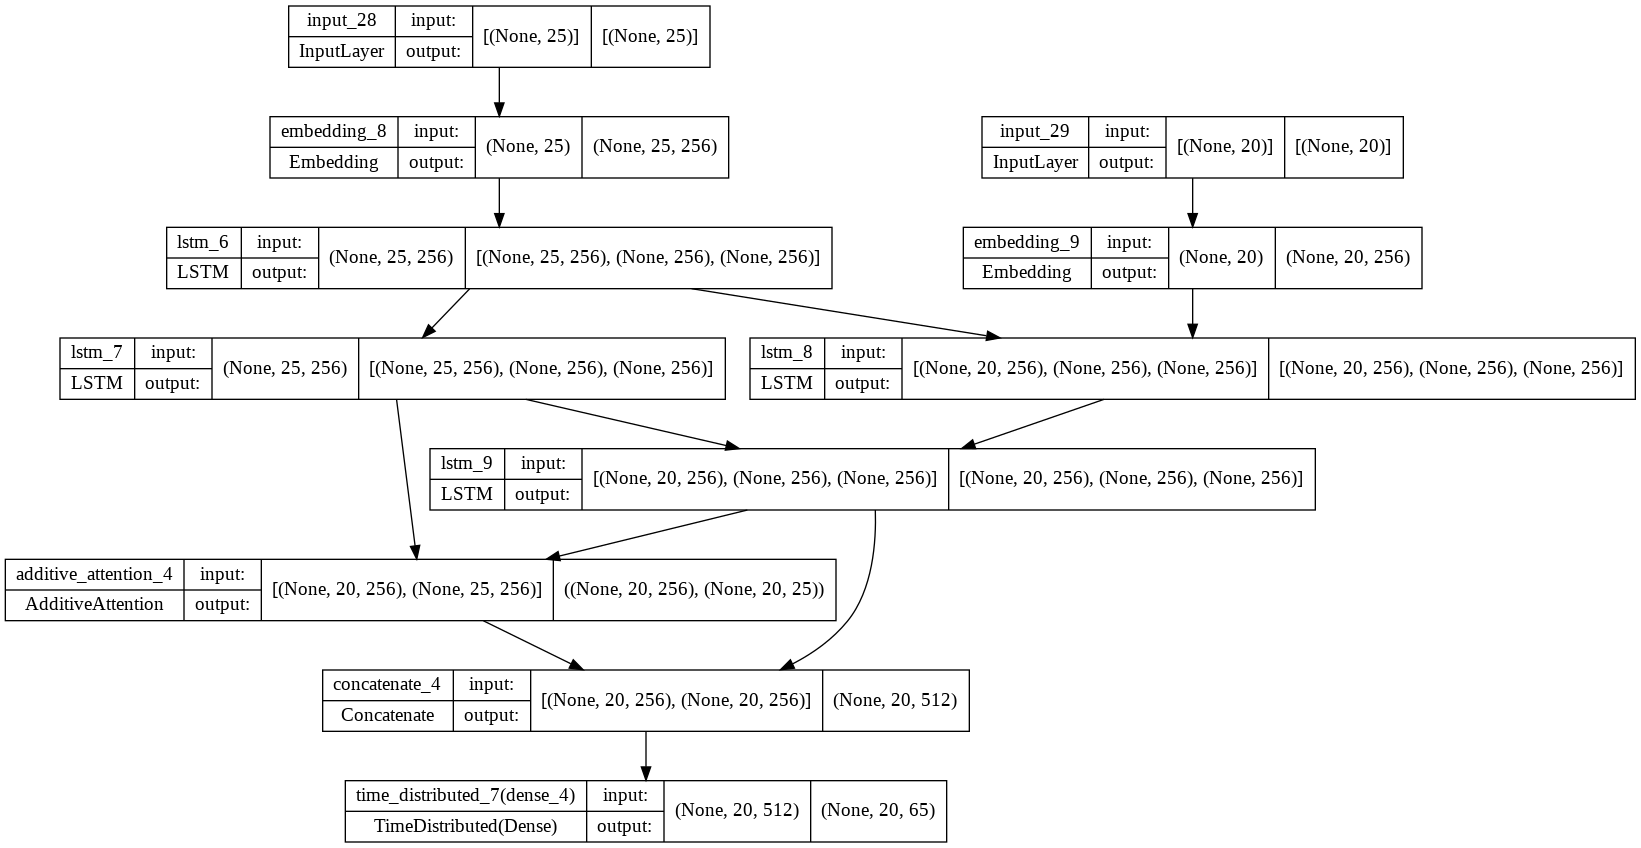

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
def inferencing(model, num_encoders, num_decoders, enc_layers, dec_layers, cell, hidden_layer_size):


    # ENCODER MODEL RECONSTRUCTION 
    enc_in = model.input[0]  # input_1
    EmbeddingLayer = model.layers[2]    
    enc_out = EmbeddingLayer(enc_in)

    enc_states = []

    if cell == 'RNN':
        for i in range(num_encoders):
            enc_out, state_h = enc_layers[i](enc_out)
            enc_states += [state_h] 
    elif cell == 'LSTM':
        for i in range(num_encoders):
            enc_out, state_h, state_c = enc_layers[i](enc_out)
            enc_states += [state_h, state_c]   
    elif cell == 'GRU':
        for i in range(num_encoders):
            enc_out, state_h = enc_layers[i](enc_out)
            enc_states += [state_h] 

    encoder = Model(enc_in, enc_states + [enc_out])


    

    dec_in = model.input[1]    
    EmbeddingLayer = model.layers[3] 
    dec_out = EmbeddingLayer(dec_in)

    dec_states = []
    dec_initial_states = []
    
    if cell == 'RNN' :
        for i in range(num_decoders):
            dec_initial_states += [Input(shape=(hidden_layer_size,))]
            dec_out, state_h = dec_layers[i](dec_out, initial_state = dec_initial_states[i])
            dec_states += [state_h]
    elif cell == "LSTM":
        j=0
        for i in range(num_decoders):
            dec_initial_states += [Input(shape=(hidden_layer_size, )) , Input(shape=(hidden_layer_size, ))]
            dec_out, state_h, state_c = dec_layers[i](dec_out, initial_state=dec_initial_states[i+j:i+j+2])
            dec_states += [state_h , state_c]
            j += 1
    elif cell == "GRU":
        for i in range(num_decoders):
            dec_initial_states += [Input(shape=(hidden_layer_size,))]
            dec_out, state_h = dec_layers[i](dec_out, initial_state = dec_initial_states[i])
            dec_states += [state_h]

    attention_layer = model.layers[4+2*num_encoders]
    attention_input = Input(shape=(max_encoder_seq_length,hidden_layer_size))   

    context_vec, attention_weights = attention_layer([dec_out, attention_input], return_attention_scores=True)
    
    concat_layer = model.layers[5+2*num_encoders]
    dec_out = concat_layer([dec_out, context_vec])

    dec_dense = model.layers[6+2*num_encoders]
    dec_out = dec_dense(dec_out)
    decoder = Model([dec_in] + dec_initial_states + [attention_input], [dec_out] + dec_states + [attention_weights])

    return encoder, decoder

In [ ]:
def decode_sequence(input_seq, encoder, decoder):
    # Encode the input as state vectors.
    states_value = encoder.predict(input_seq)
    attention_input = states_value[-1]

    states_value = states_value[:-1]
    
    target_seq = np.zeros((1, 1)) 
    target_seq[0, 0] = target_token_index["\t"]
    
    attention_weights = []
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens = decoder.predict([target_seq] + states_value + [attention_input])
        sampled_token_index = np.argmax(output_tokens[0][0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = output_tokens[1:-1]
        attention_weights.append(output_tokens[-1][0][0])
        
    return decoded_sentence, attention_weights

In [ ]:
num_encoder_layers = 1
num_decoder_layers = 1

In [ ]:
encoder_model, decoder_model = inferencing(model, num_encoder_layers, num_decoder_layers, encoder_layers, decoder_layers, cell_type, hidden_layer_size)
correct = 0
n = target.shape[0]
for i in range(20):
    inputs = encoder_input_data[i:i+1]
    output,atw = decode_sequence(inputs,encoder_model, decoder_model)
    print("-")
    print("Input sentence:", input[i])
    print("Decoded sentence:", output)

-
Input sentence: amkita
Decoded sentence: అంకిత

-
Input sentence: ankita
Decoded sentence: అంకిట

-
Input sentence: ankitha
Decoded sentence: అంకిత

-
Input sentence: ankitam
Decoded sentence: అంకితం

-
Input sentence: ankitham
Decoded sentence: అంకితం

-
Input sentence: ankitabaavam
Decoded sentence: అంకితబావం

-
Input sentence: ankithabhavam
Decoded sentence: అంకితభావం

-
Input sentence: ankatamicchaadu
Decoded sentence: అంకటమిచ్చాడు

-
Input sentence: ankitamicchadu
Decoded sentence: అంకితమిచ్చాడు

-
Input sentence: ankitamichhaadu
Decoded sentence: అంకితమిచ్చాడు

-
Input sentence: ankithamicchaadu
Decoded sentence: అంకితమిచ్చాడు

-
Input sentence: ankithamichhaadu
Decoded sentence: అంకితమిచ్చాడు

-
Input sentence: amkithamichaaru
Decoded sentence: అంకితమిచ్చారు

-
Input sentence: ankithamichaaru
Decoded sentence: అంకితమిచ్చారు

-
Input sentence: ankithamicharu
Decoded sentence: అంకితమిచ్చారు

-
Input sentence: ankithamaina
Decoded sentence: అంకితమైన

-
Input sentence: ankusham
De

In [ ]:
def train_model(config, encoder_input, decoder_input, decoder_target, encoder_val_input, decoder_val_input, decoder_val_target ):

    batch_size = config['batch_size']
    cell = config['cell']
    embed_size = config['embed_size']
    dropout = config['dropout']
    num_encoders = config['num_encoders']
    num_decoders = config['num_decoders']
    hidden_layer_size = config['hidden_layer_size']
    epochs = config['epochs']
    optimizer = config['optimizer']


    model, encoder_layers, decoder_layers = build_model(num_encoders, num_decoders, cell, embed_size, dropout, hidden_layer_size)

    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

    model.fit(
    [encoder_input, decoder_input],
    decoder_target,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = True,
    validation_data= ([encoder_val_input, decoder_val_input], decoder_val_target)
    )

    return model

In [ ]:

# Enter the project and the entity name for wandb sweeps
project_name = "Assignment 3"
entity_name = "safikhan"

In [ ]:
def train():
  default_config={
      "cell": "RNN",
      "embed_size":256,
      "dropout":0.2,
      "num_layers": 1,
      "hidden_layer_size":128,
      "epochs": 1,
      "batch_size": 64,
      "optimizer": 'adam'
  }

  wandb.init(config=default_config, project=project_name, entity=entity_name)
  config = wandb.config
  wandb.run.name = "ATT"+str(config.cell)\
      +"_"+str(config.embed_size)\
      +"_"+str(config.dropout)\
      +"_"+str(config.num_layers)\
      +"_"+str(config.num_layers)\
      +"_"+str(config.hidden_layer_size)\
      +"_"+str(config.epochs)\
      +"_"+str(config.batch_size)

  #wandb.run.save()
  
  
  batch_size = config['batch_size']
  cell = config['cell']
  embed_size = config['embed_size']
  dropout = config['dropout']
  num_encoders = config['num_layers']
  num_decoders = config['num_layers']
  hidden_layer_size = config['hidden_layer_size']
  epochs = config['epochs']
  optimizer = config['optimizer']


  model, encoder_layers, decoder_layers = build_model(num_encoders, num_decoders, cell, embed_size, dropout, hidden_layer_size)

  
  model.compile(
      optimizer = optimizer,
      loss = tf.keras.losses.CategoricalCrossentropy(name='loss'),
      metrics = [tf.keras.metrics.CategoricalAccuracy(name='acc')]
  )
  
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size = batch_size,
      epochs = epochs,
      shuffle = True,
      callbacks=[WandbCallback()],
      validation_data= ([encoder_val_input_data, decoder_val_input_data], decoder_val_target_data)
  )

  

#   encoder_model, decoder_model = inferencing(model, num_encoders, num_decoders, encoder_layers, decoder_layers, cell_type, hidden_layer_size)

#   correct = 0
#   n = input.shape[0]
#   for i in range(n):
#     inputs = encoder_input_data[i:i+1]
#     output = decode_sequence(inputs,encoder_model, decoder_model)
#     # print("-")
#     # print("Input sentence:", input[i])
#     # print("Decoded sentence:", output)

#     if output.strip() == target[i].strip():
#             correct += 1

#   print("The TRAIN accuracy based on full matching is: ", correct/n)

#   wandb.log({'Full_Train_Accuracy' : correct/n})



#   correct = 0
#   n = val_input.shape[0]
#   for i in range(n):
#     inputs = encoder_val_input_data[i:i+1]
#     output = decode_sequence(inputs,encoder_model, decoder_model)
#     # print("-")
#     # print("Input sentence:", input[i])
#     # print("Decoded sentence:", output)

#     if output.strip() == val_target[i].strip():
#             correct += 1

#   print("The VAL accuracy based on full matching is: ", correct/n)

#   wandb.log({'Full_Val_Accuracy' : correct/n})

  wandb.run.finish()
  

In [ ]:
hyperparameters = {

          "cell":{
              "values":["RNN","GRU","LSTM"]
              },

          "embed_size":{
              "values":[16,32,64,256]
              },

          "hidden_layer_size":{
              "values":[16,32,64,256]
              },

          "num_layers":{
              "values":[1,2,3]
              },

          "dropout":{
              "values":[0.2,0.3,0.4]
              },

          "epochs":{
              "values":[5,10,15,20]
              },

          "batch_size":{
              "values":[32,64]
              },

          "optimizer":{
              "values":["adam", "rmsprop", "nadam"]
              }
      }

In [ ]:
def sweeper(project_name,entity_name):
  sweep_config={

      "method": "bayes",
      "metric": {
          "name": "val_acc", 
          "goal": "maximize"
          },
      "parameters":hyperparameters
  }

  sweep_id=wandb.sweep(sweep_config, project=project_name, entity=entity_name)
  wandb.agent(sweep_id,train)


In [ ]:
# Running the sweeps for hyperparameter tuning
sweeper(project_name,entity_name)

Create sweep with ID: d3vyr277
Sweep URL: https://wandb.ai/safikhan/Assignment%203/sweeps/d3vyr277


wandb: Agent Starting Run: bh8l3tfb with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.3
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 188s 101ms/step - loss: 0.9142 - acc: 0.1935 - val_loss: 0.5704 - val_acc: 0.2534 - _timestamp: 1651384263.0000 - _runtime: 194.0000
Epoch 2/5
1830/1830 [==============================] - 182s 99ms/step - loss: 0.5426 - acc: 0.2859 - val_loss: 0.3062 - val_acc: 0.3285 - _timestamp: 1651384445.0000 - _runtime: 376.0000
Epoch 3/5
1830/1830 [==============================] - 181s 99ms/step - loss: 0.3457 - acc: 0.3444 - val_loss: 0.2010 - val_acc: 0.3592 - _timestamp: 1651384626.0000 - _runtime: 557.0000
Epoch 4/5
1830/1830 [==============================] - 181s 99ms/step - loss: 0.2512 - acc: 0.3731 - val_loss: 0.1737 - val_acc: 0.3670 - _timestamp: 1651384807.0000 - _runtime: 738.0000
Epoch 5/5
1830/1830 [==============================] - 180s 99ms/step - loss: 0.2129 - acc: 0.3843 - val_loss: 0.1604 - val_acc: 0.3708 - _timestamp: 1651384987.0000 - _runtime: 918.0000


acc,▁▄▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_acc,▁▅▇██
val_loss,█▃▂▁▁
acc,0.38426
best_epoch,4
best_val_loss,0.16044
epoch,4
loss,0.21293
val_acc,0.37083


wandb: Agent Starting Run: vx53yiwb with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 18s 13ms/step - loss: 0.9693 - acc: 0.1744 - val_loss: 0.6726 - val_acc: 0.2285 - _timestamp: 1651385022.0000 - _runtime: 24.0000
Epoch 2/5
915/915 [==============================] - 11s 12ms/step - loss: 0.5595 - acc: 0.2807 - val_loss: 0.3902 - val_acc: 0.3010 - _timestamp: 1651385033.0000 - _runtime: 35.0000
Epoch 3/5
915/915 [==============================] - 11s 12ms/step - loss: 0.3486 - acc: 0.3408 - val_loss: 0.2638 - val_acc: 0.3378 - _timestamp: 1651385044.0000 - _runtime: 46.0000
Epoch 4/5
915/915 [==============================] - 11s 12ms/step - loss: 0.2265 - acc: 0.3789 - val_loss: 0.1924 - val_acc: 0.3609 - _timestamp: 1651385055.0000 - _runtime: 57.0000
Epoch 5/5
915/915 [==============================] - 11s 12ms/step - loss: 0.1575 - acc: 0.4007 - val_loss: 0.1631 - val_acc: 0.3707 - _timestamp: 1651385066.0000 - _runtime: 68.0000


acc,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_acc,▁▅▆██
val_loss,█▄▂▁▁
acc,0.40074
best_epoch,4
best_val_loss,0.16309
epoch,4
loss,0.15748
val_acc,0.37074


wandb: Agent Starting Run: a7vv60ec with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.3
wandb: 	embed_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 16
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 278s 149ms/step - loss: 1.2294 - acc: 0.1085 - val_loss: 1.0380 - val_acc: 0.1306 - _timestamp: 1651385360.0000 - _runtime: 285.0000
Epoch 2/10
1830/1830 [==============================] - 271s 148ms/step - loss: 1.0820 - acc: 0.1425 - val_loss: 0.9318 - val_acc: 0.1554 - _timestamp: 1651385631.0000 - _runtime: 556.0000
Epoch 3/10
1830/1830 [==============================] - 271s 148ms/step - loss: 0.9995 - acc: 0.1612 - val_loss: 0.8656 - val_acc: 0.1704 - _timestamp: 1651385901.0000 - _runtime: 826.0000
Epoch 4/10
1830/1830 [==============================] - 270s 148ms/step - loss: 0.9475 - acc: 0.1724 - val_loss: 0.8174 - val_acc: 0.1831 - _timestamp: 1651386171.0000 - _runtime: 1096.0000
Epoch 5/10
1830/1830 [==============================] - 269s 147ms/step - loss: 0.8973 - acc: 0.1835 - val_loss: 0.7614 - val_acc: 0.1948 - _timestamp: 1651386441.0000 - _runtime: 1366.0000
Epoch 6/10
1830/1830 [==============================]

acc,▁▃▄▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▁▁
val_acc,▁▃▄▅▅▆▇███
val_loss,█▆▅▄▄▃▂▂▁▁
acc,0.23589
best_epoch,9
best_val_loss,0.60221
epoch,9
loss,0.68435
val_acc,0.23254


wandb: Agent Starting Run: yuvh4xab with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 64
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 16s 12ms/step - loss: 1.0699 - acc: 0.1526 - val_loss: 0.7114 - val_acc: 0.2209 - _timestamp: 1651387818.0000 - _runtime: 22.0000
Epoch 2/15
915/915 [==============================] - 10s 11ms/step - loss: 0.5972 - acc: 0.2729 - val_loss: 0.3504 - val_acc: 0.3167 - _timestamp: 1651387828.0000 - _runtime: 32.0000
Epoch 3/15
915/915 [==============================] - 10s 11ms/step - loss: 0.3289 - acc: 0.3502 - val_loss: 0.2132 - val_acc: 0.3560 - _timestamp: 1651387839.0000 - _runtime: 43.0000
Epoch 4/15
915/915 [==============================] - 11s 12ms/step - loss: 0.2302 - acc: 0.3791 - val_loss: 0.1741 - val_acc: 0.3670 - _timestamp: 1651387850.0000 - _runtime: 54.0000
Epoch 5/15
915/915 [==============================] - 10s 11ms/step - loss: 0.1907 - acc: 0.3905 - val_loss: 0.1555 - val_acc: 0.3722 - _timestamp: 1651387860.0000 - _runtime: 64.0000
Epoch 6/15
915/915 [==============================] - 10s 11ms/step - loss: 0.16

acc,▁▄▆▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇███████████
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁
acc,0.41251
best_epoch,14
best_val_loss,0.11944
epoch,14
loss,0.11629
val_acc,0.38364


wandb: Agent Starting Run: 6i91tlmb with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.3
wandb: 	embed_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 95s 100ms/step - loss: 0.6684 - acc: 0.2561 - val_loss: 0.2902 - val_acc: 0.3325 - _timestamp: 1651388080.0000 - _runtime: 102.0000
Epoch 2/10
915/915 [==============================] - 91s 99ms/step - loss: 0.2830 - acc: 0.3613 - val_loss: 0.1692 - val_acc: 0.3693 - _timestamp: 1651388170.0000 - _runtime: 192.0000
Epoch 3/10
915/915 [==============================] - 90s 99ms/step - loss: 0.1926 - acc: 0.3896 - val_loss: 0.1442 - val_acc: 0.3762 - _timestamp: 1651388261.0000 - _runtime: 283.0000
Epoch 4/10
915/915 [==============================] - 90s 99ms/step - loss: 0.1631 - acc: 0.3983 - val_loss: 0.1368 - val_acc: 0.3787 - _timestamp: 1651388351.0000 - _runtime: 373.0000
Epoch 5/10
915/915 [==============================] - 91s 100ms/step - loss: 0.1488 - acc: 0.4029 - val_loss: 0.1303 - val_acc: 0.3801 - _timestamp: 1651388442.0000 - _runtime: 464.0000
Epoch 6/10
915/915 [==============================] - 90s 98ms/step - los

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
acc,0.41192
best_epoch,9
best_val_loss,0.12452
epoch,9
loss,0.11773
val_acc,0.38354


wandb: Agent Starting Run: llsbki5t with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 25s 19ms/step - loss: 0.5763 - acc: 0.2830 - val_loss: 0.1749 - val_acc: 0.3684 - _timestamp: 1651388936.0000 - _runtime: 32.0000
Epoch 2/15
915/915 [==============================] - 16s 17ms/step - loss: 0.1492 - acc: 0.4031 - val_loss: 0.1279 - val_acc: 0.3808 - _timestamp: 1651388952.0000 - _runtime: 48.0000
Epoch 3/15
915/915 [==============================] - 16s 17ms/step - loss: 0.1086 - acc: 0.4151 - val_loss: 0.1159 - val_acc: 0.3849 - _timestamp: 1651388967.0000 - _runtime: 63.0000
Epoch 4/15
915/915 [==============================] - 16s 17ms/step - loss: 0.0904 - acc: 0.4209 - val_loss: 0.1158 - val_acc: 0.3858 - _timestamp: 1651388983.0000 - _runtime: 79.0000
Epoch 5/15
915/915 [==============================] - 16s 17ms/step - loss: 0.0779 - acc: 0.4247 - val_loss: 0.1167 - val_acc: 0.3858 - _timestamp: 1651388999.0000 - _runtime: 95.0000
Epoch 6/15
915/915 [==============================] - 16s 17ms/step - loss: 0.06

acc,▁▆▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇▇▇███████
val_loss,█▂▁▁▁▁▁▂▂▂▂▂▃▃▃
acc,0.4375
best_epoch,3
best_val_loss,0.11584
epoch,14
loss,0.03596
val_acc,0.38762


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uz24d326 with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 24s 18ms/step - loss: 0.5201 - acc: 0.3014 - val_loss: 0.1543 - val_acc: 0.3738 - _timestamp: 1651389207.0000 - _runtime: 32.0000
Epoch 2/15
915/915 [==============================] - 15s 17ms/step - loss: 0.1459 - acc: 0.4039 - val_loss: 0.1258 - val_acc: 0.3812 - _timestamp: 1651389222.0000 - _runtime: 47.0000
Epoch 3/15
915/915 [==============================] - 15s 17ms/step - loss: 0.1153 - acc: 0.4130 - val_loss: 0.1168 - val_acc: 0.3845 - _timestamp: 1651389238.0000 - _runtime: 63.0000
Epoch 4/15
915/915 [==============================] - 15s 17ms/step - loss: 0.0999 - acc: 0.4176 - val_loss: 0.1144 - val_acc: 0.3861 - _timestamp: 1651389253.0000 - _runtime: 78.0000
Epoch 5/15
915/915 [==============================] - 15s 17ms/step - loss: 0.0894 - acc: 0.4207 - val_loss: 0.1129 - val_acc: 0.3867 - _timestamp: 1651389268.0000 - _runtime: 93.0000
Epoch 6/15
915/915 [==============================] - 16s 17ms/step - loss: 0.08

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇▇▇▇▇████▇▇█
val_loss,█▃▂▁▁▁▁▁▁▂▂▂▂▃▃
acc,0.43362
best_epoch,6
best_val_loss,0.1116
epoch,14
loss,0.04734
val_acc,0.38941


wandb: Agent Starting Run: b7ygf4fn with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 17s 14ms/step - loss: 0.5701 - acc: 0.2875 - val_loss: 0.1591 - val_acc: 0.3724 - _timestamp: 1651389458.0000 - _runtime: 24.0000
Epoch 2/10
915/915 [==============================] - 12s 13ms/step - loss: 0.1401 - acc: 0.4060 - val_loss: 0.1272 - val_acc: 0.3812 - _timestamp: 1651389470.0000 - _runtime: 36.0000
Epoch 3/10
915/915 [==============================] - 12s 13ms/step - loss: 0.1085 - acc: 0.4152 - val_loss: 0.1162 - val_acc: 0.3846 - _timestamp: 1651389481.0000 - _runtime: 47.0000
Epoch 4/10
915/915 [==============================] - 12s 13ms/step - loss: 0.0928 - acc: 0.4201 - val_loss: 0.1158 - val_acc: 0.3852 - _timestamp: 1651389493.0000 - _runtime: 59.0000
Epoch 5/10
915/915 [==============================] - 12s 13ms/step - loss: 0.0819 - acc: 0.4234 - val_loss: 0.1135 - val_acc: 0.3863 - _timestamp: 1651389505.0000 - _runtime: 71.0000
Epoch 6/10
915/915 [==============================] - 12s 13ms/step - loss: 0.07

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▃▁▁▁▁▂▂▂▃
acc,0.43263
best_epoch,4
best_val_loss,0.11353
epoch,9
loss,0.05206
val_acc,0.38647


wandb: Agent Starting Run: w53888e5 with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 88s 47ms/step - loss: 0.4084 - acc: 0.3299 - val_loss: 0.1644 - val_acc: 0.3702 - _timestamp: 1651389670.0000 - _runtime: 95.0000
Epoch 2/5
1830/1830 [==============================] - 84s 46ms/step - loss: 0.1588 - acc: 0.3992 - val_loss: 0.1414 - val_acc: 0.3758 - _timestamp: 1651389754.0000 - _runtime: 179.0000
Epoch 3/5
1830/1830 [==============================] - 84s 46ms/step - loss: 0.1369 - acc: 0.4059 - val_loss: 0.1341 - val_acc: 0.3790 - _timestamp: 1651389837.0000 - _runtime: 262.0000
Epoch 4/5
1830/1830 [==============================] - 85s 46ms/step - loss: 0.1241 - acc: 0.4098 - val_loss: 0.1334 - val_acc: 0.3800 - _timestamp: 1651389922.0000 - _runtime: 347.0000
Epoch 5/5
1830/1830 [==============================] - 84s 46ms/step - loss: 0.1155 - acc: 0.4124 - val_loss: 0.1298 - val_acc: 0.3802 - _timestamp: 1651390006.0000 - _runtime: 431.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇██
val_loss,█▃▂▂▁
acc,0.41245
best_epoch,4
best_val_loss,0.12976
epoch,4
loss,0.11554
val_acc,0.38018


wandb: Agent Starting Run: 8khnw4zy with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 17s 14ms/step - loss: 0.6007 - acc: 0.2786 - val_loss: 0.1657 - val_acc: 0.3708 - _timestamp: 1651390046.0000 - _runtime: 25.0000
Epoch 2/20
915/915 [==============================] - 12s 13ms/step - loss: 0.1427 - acc: 0.4050 - val_loss: 0.1285 - val_acc: 0.3808 - _timestamp: 1651390058.0000 - _runtime: 37.0000
Epoch 3/20
915/915 [==============================] - 12s 13ms/step - loss: 0.1089 - acc: 0.4152 - val_loss: 0.1174 - val_acc: 0.3839 - _timestamp: 1651390070.0000 - _runtime: 49.0000
Epoch 4/20
915/915 [==============================] - 12s 13ms/step - loss: 0.0928 - acc: 0.4201 - val_loss: 0.1150 - val_acc: 0.3853 - _timestamp: 1651390081.0000 - _runtime: 60.0000
Epoch 5/20
915/915 [==============================] - 12s 13ms/step - loss: 0.0814 - acc: 0.4235 - val_loss: 0.1151 - val_acc: 0.3855 - _timestamp: 1651390093.0000 - _runtime: 72.0000
Epoch 6/20
915/915 [==============================] - 12s 13ms/step - loss: 0.07

acc,▁▇▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇████████████▇▇█
val_loss,█▃▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▅▅▅
acc,0.43949
best_epoch,3
best_val_loss,0.11499
epoch,19
loss,0.02965
val_acc,0.38596


wandb: Agent Starting Run: ibixvont with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 45s 47ms/step - loss: 0.5544 - acc: 0.2912 - val_loss: 0.1764 - val_acc: 0.3670 - _timestamp: 1651390330.0000 - _runtime: 52.0000
Epoch 2/5
915/915 [==============================] - 42s 46ms/step - loss: 0.1594 - acc: 0.3998 - val_loss: 0.1429 - val_acc: 0.3754 - _timestamp: 1651390372.0000 - _runtime: 94.0000
Epoch 3/5
915/915 [==============================] - 42s 46ms/step - loss: 0.1305 - acc: 0.4080 - val_loss: 0.1307 - val_acc: 0.3801 - _timestamp: 1651390414.0000 - _runtime: 136.0000
Epoch 4/5
915/915 [==============================] - 42s 46ms/step - loss: 0.1163 - acc: 0.4122 - val_loss: 0.1287 - val_acc: 0.3809 - _timestamp: 1651390456.0000 - _runtime: 178.0000
Epoch 5/5
915/915 [==============================] - 42s 46ms/step - loss: 0.1070 - acc: 0.4152 - val_loss: 0.1252 - val_acc: 0.3814 - _timestamp: 1651390498.0000 - _runtime: 220.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▅▇██
val_loss,█▃▂▁▁
acc,0.41519
best_epoch,4
best_val_loss,0.1252
epoch,4
loss,0.10704
val_acc,0.38144


wandb: Agent Starting Run: 1ox2s7wz with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4893 - acc: 0.3065 - val_loss: 0.1680 - val_acc: 0.3698 - _timestamp: 1651390545.0000 - _runtime: 35.0000
Epoch 2/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.1278 - acc: 0.4099 - val_loss: 0.1242 - val_acc: 0.3824 - _timestamp: 1651390566.0000 - _runtime: 56.0000
Epoch 3/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0909 - acc: 0.4207 - val_loss: 0.1157 - val_acc: 0.3846 - _timestamp: 1651390587.0000 - _runtime: 77.0000
Epoch 4/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0731 - acc: 0.4263 - val_loss: 0.1159 - val_acc: 0.3860 - _timestamp: 1651390609.0000 - _runtime: 99.0000
Epoch 5/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0615 - acc: 0.4299 - val_loss: 0.1156 - val_acc: 0.3863 - _timestamp: 1651390630.0000 - _runtime: 120.0000
Epoch 6/20
1830/1830 [==============================] - 21s 12ms/step

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇███▇▇███▇▇██▇▇▇▇
val_loss,█▂▁▁▁▁▂▃▃▃▄▄▅▅▄▆▆▆▆▇
acc,0.44271
best_epoch,4
best_val_loss,0.11558
epoch,19
loss,0.01949
val_acc,0.38615


wandb: Agent Starting Run: eyfbnwye with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 17s 14ms/step - loss: 0.5522 - acc: 0.2917 - val_loss: 0.1574 - val_acc: 0.3729 - _timestamp: 1651390984.0000 - _runtime: 25.0000
Epoch 2/5
915/915 [==============================] - 12s 13ms/step - loss: 0.1332 - acc: 0.4079 - val_loss: 0.1260 - val_acc: 0.3813 - _timestamp: 1651390995.0000 - _runtime: 36.0000
Epoch 3/5
915/915 [==============================] - 12s 13ms/step - loss: 0.1024 - acc: 0.4172 - val_loss: 0.1163 - val_acc: 0.3855 - _timestamp: 1651391007.0000 - _runtime: 48.0000
Epoch 4/5
915/915 [==============================] - 12s 13ms/step - loss: 0.0861 - acc: 0.4222 - val_loss: 0.1167 - val_acc: 0.3854 - _timestamp: 1651391019.0000 - _runtime: 60.0000
Epoch 5/5
915/915 [==============================] - 12s 13ms/step - loss: 0.0749 - acc: 0.4257 - val_loss: 0.1164 - val_acc: 0.3850 - _timestamp: 1651391030.0000 - _runtime: 71.0000


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆███
val_loss,█▃▁▁▁
acc,0.42573
best_epoch,2
best_val_loss,0.1163
epoch,4
loss,0.07485
val_acc,0.38496


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n25l9xxa with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 109s 58ms/step - loss: 0.5019 - acc: 0.3053 - val_loss: 0.1736 - val_acc: 0.3676 - _timestamp: 1651391248.0000 - _runtime: 116.0000
Epoch 2/10
1830/1830 [==============================] - 105s 57ms/step - loss: 0.1575 - acc: 0.4001 - val_loss: 0.1472 - val_acc: 0.3755 - _timestamp: 1651391353.0000 - _runtime: 221.0000
Epoch 3/10
1830/1830 [==============================] - 105s 57ms/step - loss: 0.1327 - acc: 0.4075 - val_loss: 0.1355 - val_acc: 0.3785 - _timestamp: 1651391458.0000 - _runtime: 326.0000
Epoch 4/10
1830/1830 [==============================] - 104s 57ms/step - loss: 0.1202 - acc: 0.4114 - val_loss: 0.1376 - val_acc: 0.3781 - _timestamp: 1651391562.0000 - _runtime: 430.0000
Epoch 5/10
1830/1830 [==============================] - 104s 57ms/step - loss: 0.1110 - acc: 0.4139 - val_loss: 0.1333 - val_acc: 0.3797 - _timestamp: 1651391666.0000 - _runtime: 534.0000
Epoch 6/10
1830/1830 [==============================] - 105s

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇▇▇█
val_loss,█▄▂▂▁▂▂▁▂▁
acc,0.4206
best_epoch,9
best_val_loss,0.13072
epoch,9
loss,0.08951
val_acc,0.3821


wandb: Agent Starting Run: oaqc15er with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 16s 13ms/step - loss: 0.6050 - acc: 0.2767 - val_loss: 0.1839 - val_acc: 0.3660 - _timestamp: 1651392226.0000 - _runtime: 24.0000
Epoch 2/20
915/915 [==============================] - 11s 12ms/step - loss: 0.1537 - acc: 0.4022 - val_loss: 0.1309 - val_acc: 0.3800 - _timestamp: 1651392237.0000 - _runtime: 35.0000
Epoch 3/20
915/915 [==============================] - 11s 12ms/step - loss: 0.1118 - acc: 0.4144 - val_loss: 0.1162 - val_acc: 0.3842 - _timestamp: 1651392249.0000 - _runtime: 47.0000
Epoch 4/20
915/915 [==============================] - 11s 12ms/step - loss: 0.0930 - acc: 0.4199 - val_loss: 0.1126 - val_acc: 0.3861 - _timestamp: 1651392260.0000 - _runtime: 58.0000
Epoch 5/20
915/915 [==============================] - 11s 12ms/step - loss: 0.0804 - acc: 0.4240 - val_loss: 0.1107 - val_acc: 0.3861 - _timestamp: 1651392272.0000 - _runtime: 70.0000
Epoch 6/20
915/915 [==============================] - 11s 12ms/step - loss: 0.07

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇██▇████▇██▇███
val_loss,█▃▂▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄
acc,0.44144
best_epoch,5
best_val_loss,0.11065
epoch,19
loss,0.02356
val_acc,0.38839


wandb: Agent Starting Run: 4vugkl8w with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 36s 28ms/step - loss: 0.8071 - acc: 0.2164 - val_loss: 0.3980 - val_acc: 0.2993 - _timestamp: 1651392501.0000 - _runtime: 45.0000
Epoch 2/5
915/915 [==============================] - 23s 25ms/step - loss: 0.2674 - acc: 0.3660 - val_loss: 0.1618 - val_acc: 0.3714 - _timestamp: 1651392525.0000 - _runtime: 69.0000
Epoch 3/5
915/915 [==============================] - 23s 25ms/step - loss: 0.1389 - acc: 0.4060 - val_loss: 0.1297 - val_acc: 0.3809 - _timestamp: 1651392548.0000 - _runtime: 92.0000
Epoch 4/5
915/915 [==============================] - 23s 25ms/step - loss: 0.0989 - acc: 0.4183 - val_loss: 0.1186 - val_acc: 0.3847 - _timestamp: 1651392571.0000 - _runtime: 115.0000
Epoch 5/5
915/915 [==============================] - 23s 25ms/step - loss: 0.0782 - acc: 0.4248 - val_loss: 0.1133 - val_acc: 0.3860 - _timestamp: 1651392594.0000 - _runtime: 138.0000


acc,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁▇███
val_loss,█▂▁▁▁
acc,0.42476
best_epoch,4
best_val_loss,0.11332
epoch,4
loss,0.07819
val_acc,0.38597


wandb: Agent Starting Run: zjggr0lo with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 37s 17ms/step - loss: 0.5556 - acc: 0.2865 - val_loss: 0.1894 - val_acc: 0.3650 - _timestamp: 1651392655.0000 - _runtime: 46.0000
Epoch 2/10
1830/1830 [==============================] - 29s 16ms/step - loss: 0.1374 - acc: 0.4070 - val_loss: 0.1240 - val_acc: 0.3833 - _timestamp: 1651392684.0000 - _runtime: 75.0000
Epoch 3/10
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0889 - acc: 0.4218 - val_loss: 0.1153 - val_acc: 0.3861 - _timestamp: 1651392713.0000 - _runtime: 104.0000
Epoch 4/10
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0676 - acc: 0.4282 - val_loss: 0.1158 - val_acc: 0.3874 - _timestamp: 1651392742.0000 - _runtime: 133.0000
Epoch 5/10
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0543 - acc: 0.4323 - val_loss: 0.1139 - val_acc: 0.3876 - _timestamp: 1651392771.0000 - _runtime: 162.0000
Epoch 6/10
1830/1830 [==============================] - 29s 16ms/st

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▇███████
val_loss,█▂▁▁▁▂▂▂▂▃
acc,0.44053
best_epoch,4
best_val_loss,0.11391
epoch,9
loss,0.02738
val_acc,0.3886


wandb: Agent Starting Run: efc6cao6 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 23s 11ms/step - loss: 0.4094 - acc: 0.3316 - val_loss: 0.1408 - val_acc: 0.3775 - _timestamp: 1651392961.0000 - _runtime: 32.0000
Epoch 2/15
1830/1830 [==============================] - 18s 10ms/step - loss: 0.1171 - acc: 0.4125 - val_loss: 0.1212 - val_acc: 0.3829 - _timestamp: 1651392979.0000 - _runtime: 50.0000
Epoch 3/15
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0918 - acc: 0.4202 - val_loss: 0.1125 - val_acc: 0.3863 - _timestamp: 1651392998.0000 - _runtime: 69.0000
Epoch 4/15
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0768 - acc: 0.4249 - val_loss: 0.1135 - val_acc: 0.3867 - _timestamp: 1651393017.0000 - _runtime: 88.0000
Epoch 5/15
1830/1830 [==============================] - 18s 10ms/step - loss: 0.0660 - acc: 0.4283 - val_loss: 0.1148 - val_acc: 0.3873 - _timestamp: 1651393035.0000 - _runtime: 106.0000
Epoch 6/15
1830/1830 [==============================] - 18s 10ms/step

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇████▇▇▇▇▇██
val_loss,█▃▁▁▂▂▂▃▄▅▆▆▆▇▇
acc,0.44081
best_epoch,2
best_val_loss,0.11251
epoch,14
loss,0.02554
val_acc,0.38731


wandb: Agent Starting Run: 79bleoug with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 27s 12ms/step - loss: 0.5068 - acc: 0.3014 - val_loss: 0.1735 - val_acc: 0.3677 - _timestamp: 1651393265.0000 - _runtime: 35.0000
Epoch 2/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.1350 - acc: 0.4076 - val_loss: 0.1252 - val_acc: 0.3822 - _timestamp: 1651393287.0000 - _runtime: 57.0000
Epoch 3/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0955 - acc: 0.4193 - val_loss: 0.1142 - val_acc: 0.3851 - _timestamp: 1651393308.0000 - _runtime: 78.0000
Epoch 4/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0770 - acc: 0.4251 - val_loss: 0.1143 - val_acc: 0.3856 - _timestamp: 1651393330.0000 - _runtime: 100.0000
Epoch 5/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0651 - acc: 0.4288 - val_loss: 0.1134 - val_acc: 0.3866 - _timestamp: 1651393351.0000 - _runtime: 121.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▂▁▁▁
acc,0.42879
best_epoch,4
best_val_loss,0.11342
epoch,4
loss,0.06509
val_acc,0.38657


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vx913gjy with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 22s 10ms/step - loss: 0.3518 - acc: 0.3474 - val_loss: 0.1417 - val_acc: 0.3769 - _timestamp: 1651393402.0000 - _runtime: 30.0000
Epoch 2/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.1162 - acc: 0.4126 - val_loss: 0.1268 - val_acc: 0.3811 - _timestamp: 1651393420.0000 - _runtime: 48.0000
Epoch 3/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0934 - acc: 0.4199 - val_loss: 0.1173 - val_acc: 0.3848 - _timestamp: 1651393437.0000 - _runtime: 65.0000
Epoch 4/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0796 - acc: 0.4242 - val_loss: 0.1206 - val_acc: 0.3847 - _timestamp: 1651393454.0000 - _runtime: 82.0000
Epoch 5/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0697 - acc: 0.4273 - val_loss: 0.1209 - val_acc: 0.3850 - _timestamp: 1651393471.0000 - _runtime: 99.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅███
val_loss,█▄▁▂▂
acc,0.42725
best_epoch,2
best_val_loss,0.11728
epoch,4
loss,0.06974
val_acc,0.38503


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m9d6r330 with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 33s 25ms/step - loss: 0.5356 - acc: 0.2971 - val_loss: 0.1566 - val_acc: 0.3731 - _timestamp: 1651393533.0000 - _runtime: 42.0000
Epoch 2/10
915/915 [==============================] - 20s 22ms/step - loss: 0.1441 - acc: 0.4046 - val_loss: 0.1261 - val_acc: 0.3819 - _timestamp: 1651393553.0000 - _runtime: 62.0000
Epoch 3/10
915/915 [==============================] - 20s 22ms/step - loss: 0.1127 - acc: 0.4141 - val_loss: 0.1153 - val_acc: 0.3857 - _timestamp: 1651393574.0000 - _runtime: 83.0000
Epoch 4/10
915/915 [==============================] - 20s 22ms/step - loss: 0.0966 - acc: 0.4188 - val_loss: 0.1167 - val_acc: 0.3853 - _timestamp: 1651393594.0000 - _runtime: 103.0000
Epoch 5/10
915/915 [==============================] - 20s 22ms/step - loss: 0.0863 - acc: 0.4217 - val_loss: 0.1140 - val_acc: 0.3863 - _timestamp: 1651393614.0000 - _runtime: 123.0000
Epoch 6/10
915/915 [==============================] - 21s 22ms/step - loss: 0.

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇████
val_loss,█▃▁▁▁▁▁▁▁▂
acc,0.43009
best_epoch,5
best_val_loss,0.11395
epoch,9
loss,0.05939
val_acc,0.38801


wandb: Agent Starting Run: dwsrpvsc with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 46s 47ms/step - loss: 0.6172 - acc: 0.2726 - val_loss: 0.1955 - val_acc: 0.3610 - _timestamp: 1651393785.0000 - _runtime: 54.0000
Epoch 2/20
915/915 [==============================] - 43s 47ms/step - loss: 0.1811 - acc: 0.3934 - val_loss: 0.1462 - val_acc: 0.3748 - _timestamp: 1651393828.0000 - _runtime: 97.0000
Epoch 3/20
915/915 [==============================] - 44s 48ms/step - loss: 0.1438 - acc: 0.4040 - val_loss: 0.1353 - val_acc: 0.3785 - _timestamp: 1651393872.0000 - _runtime: 141.0000
Epoch 4/20
915/915 [==============================] - 43s 47ms/step - loss: 0.1280 - acc: 0.4087 - val_loss: 0.1287 - val_acc: 0.3801 - _timestamp: 1651393915.0000 - _runtime: 184.0000
Epoch 5/20
915/915 [==============================] - 44s 48ms/step - loss: 0.1179 - acc: 0.4117 - val_loss: 0.1245 - val_acc: 0.3816 - _timestamp: 1651393959.0000 - _runtime: 228.0000
Epoch 6/20
915/915 [==============================] - 43s 47ms/step - loss: 0

acc,▁▇▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇▇█▇███████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
acc,0.42585
best_epoch,11
best_val_loss,0.11976
epoch,19
loss,0.07193
val_acc,0.38527


wandb: Agent Starting Run: 2s6a1ghx with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 38s 17ms/step - loss: 0.5609 - acc: 0.2841 - val_loss: 0.1966 - val_acc: 0.3623 - _timestamp: 1651394669.0000 - _runtime: 47.0000
Epoch 2/20
1830/1830 [==============================] - 29s 16ms/step - loss: 0.1395 - acc: 0.4063 - val_loss: 0.1248 - val_acc: 0.3830 - _timestamp: 1651394698.0000 - _runtime: 76.0000
Epoch 3/20
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0889 - acc: 0.4216 - val_loss: 0.1126 - val_acc: 0.3869 - _timestamp: 1651394727.0000 - _runtime: 105.0000
Epoch 4/20
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0678 - acc: 0.4282 - val_loss: 0.1159 - val_acc: 0.3873 - _timestamp: 1651394756.0000 - _runtime: 134.0000
Epoch 5/20
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0542 - acc: 0.4324 - val_loss: 0.1160 - val_acc: 0.3874 - _timestamp: 1651394785.0000 - _runtime: 163.0000
Epoch 6/20
1830/1830 [==============================] - 29s 16ms/st

acc,▁▆▇▇████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇███████████████
val_loss,█▂▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅
acc,0.44348
best_epoch,2
best_val_loss,0.11265
epoch,19
loss,0.01757
val_acc,0.38881


wandb: Agent Starting Run: opbf7evn with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4836 - acc: 0.3087 - val_loss: 0.1630 - val_acc: 0.3715 - _timestamp: 1651395265.0000 - _runtime: 35.0000
Epoch 2/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.1235 - acc: 0.4114 - val_loss: 0.1238 - val_acc: 0.3824 - _timestamp: 1651395287.0000 - _runtime: 57.0000
Epoch 3/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0879 - acc: 0.4218 - val_loss: 0.1135 - val_acc: 0.3854 - _timestamp: 1651395308.0000 - _runtime: 78.0000
Epoch 4/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0700 - acc: 0.4274 - val_loss: 0.1152 - val_acc: 0.3858 - _timestamp: 1651395330.0000 - _runtime: 100.0000
Epoch 5/20
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0577 - acc: 0.4312 - val_loss: 0.1134 - val_acc: 0.3870 - _timestamp: 1651395351.0000 - _runtime: 121.0000
Epoch 6/20
1830/1830 [==============================] - 21s 12ms/ste

acc,▁▆▇▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇████▇███▇███▇█▇█
val_loss,█▂▁▁▁▂▂▃▃▄▄▅▆▆▆▆▇▇▇█
acc,0.44314
best_epoch,4
best_val_loss,0.11339
epoch,19
loss,0.01816
val_acc,0.38642


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h0xowi5e with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 54s 24ms/step - loss: 0.3726 - acc: 0.3416 - val_loss: 0.1374 - val_acc: 0.3791 - _timestamp: 1651395756.0000 - _runtime: 65.0000
Epoch 2/5
1830/1830 [==============================] - 41s 23ms/step - loss: 0.1158 - acc: 0.4132 - val_loss: 0.1241 - val_acc: 0.3833 - _timestamp: 1651395797.0000 - _runtime: 106.0000
Epoch 3/5
1830/1830 [==============================] - 41s 23ms/step - loss: 0.0934 - acc: 0.4200 - val_loss: 0.1180 - val_acc: 0.3850 - _timestamp: 1651395839.0000 - _runtime: 148.0000
Epoch 4/5
1830/1830 [==============================] - 41s 23ms/step - loss: 0.0808 - acc: 0.4237 - val_loss: 0.1209 - val_acc: 0.3853 - _timestamp: 1651395880.0000 - _runtime: 189.0000
Epoch 5/5
1830/1830 [==============================] - 41s 22ms/step - loss: 0.0731 - acc: 0.4260 - val_loss: 0.1201 - val_acc: 0.3861 - _timestamp: 1651395921.0000 - _runtime: 230.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▅▇▇█
val_loss,█▃▁▂▂
acc,0.42603
best_epoch,2
best_val_loss,0.11799
epoch,4
loss,0.07309
val_acc,0.38612


wandb: Agent Starting Run: bh53a56l with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 42s 18ms/step - loss: 0.4728 - acc: 0.3116 - val_loss: 0.1504 - val_acc: 0.3756 - _timestamp: 1651395988.0000 - _runtime: 51.0000
Epoch 2/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.1254 - acc: 0.4104 - val_loss: 0.1178 - val_acc: 0.3848 - _timestamp: 1651396020.0000 - _runtime: 83.0000
Epoch 3/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0934 - acc: 0.4199 - val_loss: 0.1087 - val_acc: 0.3870 - _timestamp: 1651396052.0000 - _runtime: 115.0000
Epoch 4/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0767 - acc: 0.4250 - val_loss: 0.1086 - val_acc: 0.3878 - _timestamp: 1651396083.0000 - _runtime: 146.0000
Epoch 5/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.0651 - acc: 0.4287 - val_loss: 0.1087 - val_acc: 0.3880 - _timestamp: 1651396116.0000 - _runtime: 179.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.42866
best_epoch,3
best_val_loss,0.10861
epoch,4
loss,0.06506
val_acc,0.38796


wandb: Agent Starting Run: c4kd7ays with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 144s 152ms/step - loss: 0.6264 - acc: 0.2657 - val_loss: 0.2411 - val_acc: 0.3465 - _timestamp: 1651396282.0000 - _runtime: 153.0000
Epoch 2/5
915/915 [==============================] - 140s 153ms/step - loss: 0.2682 - acc: 0.3651 - val_loss: 0.1697 - val_acc: 0.3687 - _timestamp: 1651396422.0000 - _runtime: 293.0000
Epoch 3/5
915/915 [==============================] - 140s 153ms/step - loss: 0.2002 - acc: 0.3867 - val_loss: 0.1463 - val_acc: 0.3752 - _timestamp: 1651396562.0000 - _runtime: 433.0000
Epoch 4/5
915/915 [==============================] - 138s 151ms/step - loss: 0.1706 - acc: 0.3959 - val_loss: 0.1410 - val_acc: 0.3777 - _timestamp: 1651396700.0000 - _runtime: 571.0000
Epoch 5/5
915/915 [==============================] - 140s 153ms/step - loss: 0.1569 - acc: 0.3998 - val_loss: 0.1325 - val_acc: 0.3799 - _timestamp: 1651396840.0000 - _runtime: 711.0000


acc,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▂▁
acc,0.39978
best_epoch,4
best_val_loss,0.13253
epoch,4
loss,0.15691
val_acc,0.37989


wandb: Agent Starting Run: 3pyqogq2 with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 23s 10ms/step - loss: 0.3571 - acc: 0.3460 - val_loss: 0.1399 - val_acc: 0.3781 - _timestamp: 1651396881.0000 - _runtime: 31.0000
Epoch 2/10
1830/1830 [==============================] - 17s 9ms/step - loss: 0.1176 - acc: 0.4123 - val_loss: 0.1260 - val_acc: 0.3821 - _timestamp: 1651396899.0000 - _runtime: 49.0000
Epoch 3/10
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0951 - acc: 0.4192 - val_loss: 0.1157 - val_acc: 0.3855 - _timestamp: 1651396916.0000 - _runtime: 66.0000
Epoch 4/10
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0812 - acc: 0.4235 - val_loss: 0.1189 - val_acc: 0.3858 - _timestamp: 1651396933.0000 - _runtime: 83.0000
Epoch 5/10
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0713 - acc: 0.4265 - val_loss: 0.1190 - val_acc: 0.3854 - _timestamp: 1651396950.0000 - _runtime: 100.0000
Epoch 6/10
1830/1830 [==============================] - 17s 9ms/step - lo

acc,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▇█▇█▇██▇
val_loss,█▄▁▂▂▂▄▄▄▆
acc,0.43485
best_epoch,2
best_val_loss,0.11571
epoch,9
loss,0.04451
val_acc,0.38556


wandb: Agent Starting Run: dvkt34kz with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 35s 15ms/step - loss: 0.3571 - acc: 0.3458 - val_loss: 0.1438 - val_acc: 0.3763 - _timestamp: 1651397095.0000 - _runtime: 43.0000
Epoch 2/15
1830/1830 [==============================] - 26s 14ms/step - loss: 0.1187 - acc: 0.4119 - val_loss: 0.1268 - val_acc: 0.3818 - _timestamp: 1651397121.0000 - _runtime: 69.0000
Epoch 3/15
1830/1830 [==============================] - 26s 14ms/step - loss: 0.0958 - acc: 0.4190 - val_loss: 0.1193 - val_acc: 0.3848 - _timestamp: 1651397147.0000 - _runtime: 95.0000
Epoch 4/15
1830/1830 [==============================] - 26s 14ms/step - loss: 0.0821 - acc: 0.4233 - val_loss: 0.1178 - val_acc: 0.3859 - _timestamp: 1651397173.0000 - _runtime: 121.0000
Epoch 5/15
1830/1830 [==============================] - 26s 14ms/step - loss: 0.0717 - acc: 0.4264 - val_loss: 0.1195 - val_acc: 0.3858 - _timestamp: 1651397199.0000 - _runtime: 147.0000
Epoch 6/15
1830/1830 [==============================] - 26s 14ms/ste

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇▇██▇████▇▇▇
val_loss,█▄▂▁▂▁▂▄▄▅▅▆▇▇█
acc,0.43607
best_epoch,5
best_val_loss,0.11699
epoch,14
loss,0.03958
val_acc,0.38629


wandb: Agent Starting Run: xkee354l with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 26s 12ms/step - loss: 0.9128 - acc: 0.1968 - val_loss: 0.5447 - val_acc: 0.2606 - _timestamp: 1651397506.0000 - _runtime: 35.0000
Epoch 2/5
1830/1830 [==============================] - 21s 11ms/step - loss: 0.4231 - acc: 0.3237 - val_loss: 0.2697 - val_acc: 0.3386 - _timestamp: 1651397526.0000 - _runtime: 55.0000
Epoch 3/5
1830/1830 [==============================] - 21s 11ms/step - loss: 0.2581 - acc: 0.3718 - val_loss: 0.2033 - val_acc: 0.3592 - _timestamp: 1651397547.0000 - _runtime: 76.0000
Epoch 4/5
1830/1830 [==============================] - 21s 11ms/step - loss: 0.2058 - acc: 0.3870 - val_loss: 0.1772 - val_acc: 0.3671 - _timestamp: 1651397568.0000 - _runtime: 97.0000
Epoch 5/5
1830/1830 [==============================] - 21s 11ms/step - loss: 0.1801 - acc: 0.3945 - val_loss: 0.1612 - val_acc: 0.3707 - _timestamp: 1651397589.0000 - _runtime: 118.0000


acc,▁▅▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
acc,0.39454
best_epoch,4
best_val_loss,0.16118
epoch,4
loss,0.18012
val_acc,0.37075


wandb: Agent Starting Run: x61eu7wz with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 156s 163ms/step - loss: 0.6161 - acc: 0.2683 - val_loss: 0.2820 - val_acc: 0.3325 - _timestamp: 1651397765.0000 - _runtime: 165.0000
Epoch 2/5
915/915 [==============================] - 147s 161ms/step - loss: 0.2740 - acc: 0.3632 - val_loss: 0.1705 - val_acc: 0.3681 - _timestamp: 1651397912.0000 - _runtime: 312.0000
Epoch 3/5
915/915 [==============================] - 148s 162ms/step - loss: 0.1893 - acc: 0.3897 - val_loss: 0.1462 - val_acc: 0.3749 - _timestamp: 1651398060.0000 - _runtime: 460.0000
Epoch 4/5
915/915 [==============================] - 147s 161ms/step - loss: 0.1568 - acc: 0.3998 - val_loss: 0.1329 - val_acc: 0.3793 - _timestamp: 1651398207.0000 - _runtime: 607.0000
Epoch 5/5
915/915 [==============================] - 148s 162ms/step - loss: 0.1402 - acc: 0.4050 - val_loss: 0.1298 - val_acc: 0.3809 - _timestamp: 1651398355.0000 - _runtime: 755.0000


acc,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
acc,0.40497
best_epoch,4
best_val_loss,0.12983
epoch,4
loss,0.14024
val_acc,0.38087


wandb: Agent Starting Run: f43tnscy with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 25s 20ms/step - loss: 0.6174 - acc: 0.2735 - val_loss: 0.1843 - val_acc: 0.3643 - _timestamp: 1651398402.0000 - _runtime: 35.0000
Epoch 2/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1549 - acc: 0.4019 - val_loss: 0.1283 - val_acc: 0.3805 - _timestamp: 1651398419.0000 - _runtime: 52.0000
Epoch 3/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1110 - acc: 0.4148 - val_loss: 0.1132 - val_acc: 0.3853 - _timestamp: 1651398436.0000 - _runtime: 69.0000
Epoch 4/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0913 - acc: 0.4206 - val_loss: 0.1082 - val_acc: 0.3873 - _timestamp: 1651398453.0000 - _runtime: 86.0000
Epoch 5/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0779 - acc: 0.4249 - val_loss: 0.1063 - val_acc: 0.3879 - _timestamp: 1651398470.0000 - _runtime: 103.0000
Epoch 6/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇████████████████
val_loss,█▃▂▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄
acc,0.44255
best_epoch,5
best_val_loss,0.10377
epoch,19
loss,0.01991
val_acc,0.38943


wandb: Agent Starting Run: k8w79qec with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 195s 105ms/step - loss: 0.4352 - acc: 0.3215 - val_loss: 0.1826 - val_acc: 0.3655 - _timestamp: 1651398941.0000 - _runtime: 203.0000
Epoch 2/5
1830/1830 [==============================] - 191s 104ms/step - loss: 0.1716 - acc: 0.3958 - val_loss: 0.1555 - val_acc: 0.3723 - _timestamp: 1651399132.0000 - _runtime: 394.0000
Epoch 3/5
1830/1830 [==============================] - 191s 104ms/step - loss: 0.1431 - acc: 0.4044 - val_loss: 0.1364 - val_acc: 0.3788 - _timestamp: 1651399323.0000 - _runtime: 585.0000
Epoch 4/5
1830/1830 [==============================] - 191s 104ms/step - loss: 0.1303 - acc: 0.4085 - val_loss: 0.1342 - val_acc: 0.3805 - _timestamp: 1651399514.0000 - _runtime: 776.0000
Epoch 5/5
1830/1830 [==============================] - 190s 104ms/step - loss: 0.1218 - acc: 0.4108 - val_loss: 0.1356 - val_acc: 0.3794 - _timestamp: 1651399704.0000 - _runtime: 966.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▄▇█▇
val_loss,█▄▁▁▁
acc,0.41082
best_epoch,3
best_val_loss,0.13422
epoch,4
loss,0.12179
val_acc,0.37938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5x9dfrgx with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 23s 11ms/step - loss: 0.5682 - acc: 0.2819 - val_loss: 0.2202 - val_acc: 0.3539 - _timestamp: 1651399756.0000 - _runtime: 32.0000
Epoch 2/15
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1493 - acc: 0.4033 - val_loss: 0.1324 - val_acc: 0.3805 - _timestamp: 1651399774.0000 - _runtime: 50.0000
Epoch 3/15
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0922 - acc: 0.4207 - val_loss: 0.1214 - val_acc: 0.3837 - _timestamp: 1651399793.0000 - _runtime: 69.0000
Epoch 4/15
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0698 - acc: 0.4276 - val_loss: 0.1204 - val_acc: 0.3850 - _timestamp: 1651399811.0000 - _runtime: 87.0000
Epoch 5/15
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0562 - acc: 0.4318 - val_loss: 0.1205 - val_acc: 0.3861 - _timestamp: 1651399830.0000 - _runtime: 106.0000
Epoch 6/15
1830/1830 [==============================] - 19s 10ms/step

acc,▁▆▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▇████████████
val_loss,█▂▁▁▁▁▂▂▂▃▃▃▃▄▃
acc,0.44289
best_epoch,3
best_val_loss,0.12043
epoch,14
loss,0.01955
val_acc,0.38587


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ifsetuc with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 24s 11ms/step - loss: 0.4188 - acc: 0.3286 - val_loss: 0.1415 - val_acc: 0.3773 - _timestamp: 1651400111.0000 - _runtime: 33.0000
Epoch 2/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1194 - acc: 0.4117 - val_loss: 0.1225 - val_acc: 0.3826 - _timestamp: 1651400130.0000 - _runtime: 52.0000
Epoch 3/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0935 - acc: 0.4198 - val_loss: 0.1123 - val_acc: 0.3860 - _timestamp: 1651400149.0000 - _runtime: 71.0000
Epoch 4/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0780 - acc: 0.4246 - val_loss: 0.1106 - val_acc: 0.3865 - _timestamp: 1651400167.0000 - _runtime: 89.0000
Epoch 5/20
1830/1830 [==============================] - 18s 10ms/step - loss: 0.0673 - acc: 0.4279 - val_loss: 0.1124 - val_acc: 0.3869 - _timestamp: 1651400186.0000 - _runtime: 108.0000
Epoch 6/20
1830/1830 [==============================] - 19s 10ms/step

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇█▇▇███▇▇▇▇▇▆▇▇
val_loss,▆▃▁▁▁▂▂▃▃▄▄▅▅▆▇▇████
acc,0.44179
best_epoch,3
best_val_loss,0.11059
epoch,19
loss,0.02181
val_acc,0.38681


wandb: Agent Starting Run: 22q71g4c with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 16s 13ms/step - loss: 0.5780 - acc: 0.2843 - val_loss: 0.1806 - val_acc: 0.3664 - _timestamp: 1651400502.0000 - _runtime: 24.0000
Epoch 2/20
915/915 [==============================] - 11s 12ms/step - loss: 0.1435 - acc: 0.4054 - val_loss: 0.1288 - val_acc: 0.3805 - _timestamp: 1651400514.0000 - _runtime: 36.0000
Epoch 3/20
915/915 [==============================] - 11s 12ms/step - loss: 0.1036 - acc: 0.4169 - val_loss: 0.1143 - val_acc: 0.3855 - _timestamp: 1651400525.0000 - _runtime: 47.0000
Epoch 4/20
915/915 [==============================] - 11s 12ms/step - loss: 0.0854 - acc: 0.4223 - val_loss: 0.1113 - val_acc: 0.3865 - _timestamp: 1651400537.0000 - _runtime: 59.0000
Epoch 5/20
915/915 [==============================] - 11s 12ms/step - loss: 0.0726 - acc: 0.4265 - val_loss: 0.1107 - val_acc: 0.3868 - _timestamp: 1651400548.0000 - _runtime: 70.0000
Epoch 6/20
915/915 [==============================] - 11s 12ms/step - loss: 0.06

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇█████████████████
val_loss,█▃▁▁▁▁▁▂▂▂▂▃▃▄▃▄▅▄▅▅
acc,0.44302
best_epoch,4
best_val_loss,0.11071
epoch,19
loss,0.01868
val_acc,0.38681


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n3nkjuen with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 42s 19ms/step - loss: 0.4782 - acc: 0.3101 - val_loss: 0.1488 - val_acc: 0.3760 - _timestamp: 1651400790.0000 - _runtime: 52.0000
Epoch 2/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.1266 - acc: 0.4103 - val_loss: 0.1175 - val_acc: 0.3852 - _timestamp: 1651400822.0000 - _runtime: 84.0000
Epoch 3/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0947 - acc: 0.4195 - val_loss: 0.1070 - val_acc: 0.3876 - _timestamp: 1651400854.0000 - _runtime: 116.0000
Epoch 4/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0781 - acc: 0.4245 - val_loss: 0.1088 - val_acc: 0.3885 - _timestamp: 1651400886.0000 - _runtime: 148.0000
Epoch 5/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0666 - acc: 0.4281 - val_loss: 0.1074 - val_acc: 0.3879 - _timestamp: 1651400917.0000 - _runtime: 179.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.42807
best_epoch,2
best_val_loss,0.10703
epoch,4
loss,0.06662
val_acc,0.38795


wandb: Agent Starting Run: mers4v0u with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 24s 11ms/step - loss: 0.5967 - acc: 0.2739 - val_loss: 0.2376 - val_acc: 0.3489 - _timestamp: 1651400965.0000 - _runtime: 34.0000
Epoch 2/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1583 - acc: 0.4006 - val_loss: 0.1342 - val_acc: 0.3796 - _timestamp: 1651400983.0000 - _runtime: 52.0000
Epoch 3/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0965 - acc: 0.4193 - val_loss: 0.1206 - val_acc: 0.3843 - _timestamp: 1651401002.0000 - _runtime: 71.0000
Epoch 4/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0730 - acc: 0.4266 - val_loss: 0.1216 - val_acc: 0.3846 - _timestamp: 1651401020.0000 - _runtime: 89.0000
Epoch 5/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0591 - acc: 0.4308 - val_loss: 0.1217 - val_acc: 0.3852 - _timestamp: 1651401039.0000 - _runtime: 108.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▇███
val_loss,█▂▁▁▁
acc,0.43083
best_epoch,2
best_val_loss,0.1206
epoch,4
loss,0.05909
val_acc,0.38523


wandb: Agent Starting Run: js3cn73z with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 26s 21ms/step - loss: 0.6415 - acc: 0.2651 - val_loss: 0.1891 - val_acc: 0.3649 - _timestamp: 1651401088.0000 - _runtime: 36.0000
Epoch 2/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1709 - acc: 0.3969 - val_loss: 0.1306 - val_acc: 0.3810 - _timestamp: 1651401105.0000 - _runtime: 53.0000
Epoch 3/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1235 - acc: 0.4106 - val_loss: 0.1153 - val_acc: 0.3847 - _timestamp: 1651401122.0000 - _runtime: 70.0000
Epoch 4/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1036 - acc: 0.4166 - val_loss: 0.1086 - val_acc: 0.3868 - _timestamp: 1651401139.0000 - _runtime: 87.0000
Epoch 5/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0903 - acc: 0.4207 - val_loss: 0.1058 - val_acc: 0.3880 - _timestamp: 1651401156.0000 - _runtime: 104.0000
Epoch 6/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇██████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃
acc,0.43931
best_epoch,5
best_val_loss,0.10273
epoch,19
loss,0.02931
val_acc,0.39062


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e2xjamyg with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 33s 25ms/step - loss: 0.5228 - acc: 0.3011 - val_loss: 0.1568 - val_acc: 0.3732 - _timestamp: 1651401472.0000 - _runtime: 42.0000
Epoch 2/10
915/915 [==============================] - 21s 22ms/step - loss: 0.1445 - acc: 0.4045 - val_loss: 0.1268 - val_acc: 0.3816 - _timestamp: 1651401493.0000 - _runtime: 63.0000
Epoch 3/10
915/915 [==============================] - 20s 22ms/step - loss: 0.1128 - acc: 0.4138 - val_loss: 0.1165 - val_acc: 0.3843 - _timestamp: 1651401513.0000 - _runtime: 83.0000
Epoch 4/10
915/915 [==============================] - 20s 22ms/step - loss: 0.0972 - acc: 0.4186 - val_loss: 0.1164 - val_acc: 0.3860 - _timestamp: 1651401534.0000 - _runtime: 104.0000
Epoch 5/10
915/915 [==============================] - 21s 23ms/step - loss: 0.0865 - acc: 0.4218 - val_loss: 0.1161 - val_acc: 0.3857 - _timestamp: 1651401554.0000 - _runtime: 124.0000
Epoch 6/10
915/915 [==============================] - 20s 22ms/step - loss: 0.

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▃▂▂▂▁▁▂▂▂
acc,0.43023
best_epoch,5
best_val_loss,0.11156
epoch,9
loss,0.05926
val_acc,0.38776


wandb: Agent Starting Run: 0ma99eni with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 38s 16ms/step - loss: 0.4443 - acc: 0.3212 - val_loss: 0.1446 - val_acc: 0.3764 - _timestamp: 1651401716.0000 - _runtime: 47.0000
Epoch 2/5
1830/1830 [==============================] - 28s 16ms/step - loss: 0.1230 - acc: 0.4109 - val_loss: 0.1218 - val_acc: 0.3833 - _timestamp: 1651401744.0000 - _runtime: 75.0000
Epoch 3/5
1830/1830 [==============================] - 28s 15ms/step - loss: 0.0949 - acc: 0.4193 - val_loss: 0.1112 - val_acc: 0.3861 - _timestamp: 1651401772.0000 - _runtime: 103.0000
Epoch 4/5
1830/1830 [==============================] - 28s 15ms/step - loss: 0.0792 - acc: 0.4242 - val_loss: 0.1093 - val_acc: 0.3880 - _timestamp: 1651401801.0000 - _runtime: 132.0000
Epoch 5/5
1830/1830 [==============================] - 28s 16ms/step - loss: 0.0671 - acc: 0.4280 - val_loss: 0.1086 - val_acc: 0.3879 - _timestamp: 1651401829.0000 - _runtime: 160.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇██
val_loss,█▄▁▁▁
acc,0.42804
best_epoch,4
best_val_loss,0.10861
epoch,4
loss,0.06708
val_acc,0.38795


wandb: Agent Starting Run: 2tuu5a6u with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 26s 21ms/step - loss: 0.6421 - acc: 0.2649 - val_loss: 0.1895 - val_acc: 0.3635 - _timestamp: 1651401878.0000 - _runtime: 35.0000
Epoch 2/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1699 - acc: 0.3972 - val_loss: 0.1335 - val_acc: 0.3792 - _timestamp: 1651401895.0000 - _runtime: 52.0000
Epoch 3/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1236 - acc: 0.4107 - val_loss: 0.1149 - val_acc: 0.3841 - _timestamp: 1651401912.0000 - _runtime: 69.0000
Epoch 4/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1038 - acc: 0.4164 - val_loss: 0.1094 - val_acc: 0.3865 - _timestamp: 1651401929.0000 - _runtime: 86.0000
Epoch 5/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0905 - acc: 0.4205 - val_loss: 0.1075 - val_acc: 0.3873 - _timestamp: 1651401946.0000 - _runtime: 103.0000
Epoch 6/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▇▇██▇████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃
acc,0.43883
best_epoch,6
best_val_loss,0.10421
epoch,19
loss,0.03093
val_acc,0.39042


wandb: Agent Starting Run: jkwd994q with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 36s 29ms/step - loss: 0.8041 - acc: 0.2174 - val_loss: 0.3591 - val_acc: 0.3106 - _timestamp: 1651402261.0000 - _runtime: 46.0000
Epoch 2/10
915/915 [==============================] - 23s 25ms/step - loss: 0.2472 - acc: 0.3731 - val_loss: 0.1509 - val_acc: 0.3751 - _timestamp: 1651402284.0000 - _runtime: 69.0000
Epoch 3/10
915/915 [==============================] - 23s 25ms/step - loss: 0.1303 - acc: 0.4089 - val_loss: 0.1218 - val_acc: 0.3827 - _timestamp: 1651402307.0000 - _runtime: 92.0000
Epoch 4/10
915/915 [==============================] - 23s 25ms/step - loss: 0.0957 - acc: 0.4193 - val_loss: 0.1157 - val_acc: 0.3851 - _timestamp: 1651402330.0000 - _runtime: 115.0000
Epoch 5/10
915/915 [==============================] - 23s 25ms/step - loss: 0.0777 - acc: 0.4248 - val_loss: 0.1102 - val_acc: 0.3868 - _timestamp: 1651402353.0000 - _runtime: 138.0000
Epoch 6/10
915/915 [==============================] - 23s 25ms/step - loss: 0.

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▇▇███████
val_loss,█▂▁▁▁▁▁▁▁▁
acc,0.43674
best_epoch,6
best_val_loss,0.10975
epoch,9
loss,0.03856
val_acc,0.38933


wandb: Agent Starting Run: 3wz84g9f with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 23s 11ms/step - loss: 0.4238 - acc: 0.3273 - val_loss: 0.1421 - val_acc: 0.3770 - _timestamp: 1651402512.0000 - _runtime: 32.0000
Epoch 2/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1205 - acc: 0.4114 - val_loss: 0.1232 - val_acc: 0.3824 - _timestamp: 1651402530.0000 - _runtime: 50.0000
Epoch 3/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0936 - acc: 0.4198 - val_loss: 0.1151 - val_acc: 0.3854 - _timestamp: 1651402549.0000 - _runtime: 69.0000
Epoch 4/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0782 - acc: 0.4246 - val_loss: 0.1125 - val_acc: 0.3862 - _timestamp: 1651402567.0000 - _runtime: 87.0000
Epoch 5/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0669 - acc: 0.4281 - val_loss: 0.1112 - val_acc: 0.3871 - _timestamp: 1651402586.0000 - _runtime: 106.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇▇█
val_loss,█▄▂▁▁
acc,0.42808
best_epoch,4
best_val_loss,0.11124
epoch,4
loss,0.06691
val_acc,0.3871


wandb: Agent Starting Run: zyf1jjib with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 22s 10ms/step - loss: 0.4175 - acc: 0.3277 - val_loss: 0.1527 - val_acc: 0.3737 - _timestamp: 1651402630.0000 - _runtime: 31.0000
Epoch 2/5
1830/1830 [==============================] - 17s 10ms/step - loss: 0.1260 - acc: 0.4100 - val_loss: 0.1256 - val_acc: 0.3823 - _timestamp: 1651402647.0000 - _runtime: 48.0000
Epoch 3/5
1830/1830 [==============================] - 17s 10ms/step - loss: 0.0993 - acc: 0.4181 - val_loss: 0.1194 - val_acc: 0.3846 - _timestamp: 1651402665.0000 - _runtime: 66.0000
Epoch 4/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0842 - acc: 0.4228 - val_loss: 0.1226 - val_acc: 0.3843 - _timestamp: 1651402682.0000 - _runtime: 83.0000
Epoch 5/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0733 - acc: 0.4262 - val_loss: 0.1211 - val_acc: 0.3843 - _timestamp: 1651402699.0000 - _runtime: 100.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▇███
val_loss,█▂▁▂▁
acc,0.42616
best_epoch,2
best_val_loss,0.11942
epoch,4
loss,0.07333
val_acc,0.3843


wandb: Agent Starting Run: g7nb2hhp with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4706 - acc: 0.3128 - val_loss: 0.1557 - val_acc: 0.3728 - _timestamp: 1651402749.0000 - _runtime: 37.0000
Epoch 2/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1235 - acc: 0.4112 - val_loss: 0.1232 - val_acc: 0.3824 - _timestamp: 1651402770.0000 - _runtime: 58.0000
Epoch 3/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0904 - acc: 0.4209 - val_loss: 0.1157 - val_acc: 0.3849 - _timestamp: 1651402792.0000 - _runtime: 80.0000
Epoch 4/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0734 - acc: 0.4262 - val_loss: 0.1147 - val_acc: 0.3860 - _timestamp: 1651402814.0000 - _runtime: 102.0000
Epoch 5/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0619 - acc: 0.4298 - val_loss: 0.1140 - val_acc: 0.3868 - _timestamp: 1651402835.0000 - _runtime: 123.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.42976
best_epoch,4
best_val_loss,0.11396
epoch,4
loss,0.06192
val_acc,0.38685


wandb: Agent Starting Run: sm2lwisr with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 155s 162ms/step - loss: 0.5979 - acc: 0.2736 - val_loss: 0.2875 - val_acc: 0.3316 - _timestamp: 1651403010.0000 - _runtime: 163.0000
Epoch 2/5
915/915 [==============================] - 146s 160ms/step - loss: 0.2697 - acc: 0.3647 - val_loss: 0.1697 - val_acc: 0.3687 - _timestamp: 1651403156.0000 - _runtime: 309.0000
Epoch 3/5
915/915 [==============================] - 147s 160ms/step - loss: 0.1889 - acc: 0.3900 - val_loss: 0.1486 - val_acc: 0.3757 - _timestamp: 1651403303.0000 - _runtime: 456.0000
Epoch 4/5
915/915 [==============================] - 146s 160ms/step - loss: 0.1562 - acc: 0.4002 - val_loss: 0.1368 - val_acc: 0.3792 - _timestamp: 1651403449.0000 - _runtime: 602.0000
Epoch 5/5
915/915 [==============================] - 146s 160ms/step - loss: 0.1402 - acc: 0.4052 - val_loss: 0.1297 - val_acc: 0.3806 - _timestamp: 1651403595.0000 - _runtime: 748.0000


acc,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
acc,0.40522
best_epoch,4
best_val_loss,0.12967
epoch,4
loss,0.14015
val_acc,0.38061


wandb: Agent Starting Run: 24krn9k5 with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 25s 20ms/step - loss: 0.6460 - acc: 0.2644 - val_loss: 0.1885 - val_acc: 0.3647 - _timestamp: 1651403649.0000 - _runtime: 34.0000
Epoch 2/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1666 - acc: 0.3984 - val_loss: 0.1320 - val_acc: 0.3797 - _timestamp: 1651403666.0000 - _runtime: 51.0000
Epoch 3/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1204 - acc: 0.4116 - val_loss: 0.1150 - val_acc: 0.3847 - _timestamp: 1651403683.0000 - _runtime: 68.0000
Epoch 4/20
915/915 [==============================] - 17s 18ms/step - loss: 0.1006 - acc: 0.4176 - val_loss: 0.1083 - val_acc: 0.3877 - _timestamp: 1651403700.0000 - _runtime: 85.0000
Epoch 5/20
915/915 [==============================] - 17s 18ms/step - loss: 0.0879 - acc: 0.4214 - val_loss: 0.1057 - val_acc: 0.3884 - _timestamp: 1651403717.0000 - _runtime: 102.0000
Epoch 6/20
915/915 [==============================] - 17s 18ms/step - loss: 0.0

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇██████████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃
acc,0.43928
best_epoch,6
best_val_loss,0.1036
epoch,19
loss,0.02969
val_acc,0.39094


wandb: Agent Starting Run: 331wer5b with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 38s 17ms/step - loss: 0.5456 - acc: 0.2885 - val_loss: 0.1881 - val_acc: 0.3646 - _timestamp: 1651404030.0000 - _runtime: 48.0000
Epoch 2/15
1830/1830 [==============================] - 29s 16ms/step - loss: 0.1361 - acc: 0.4074 - val_loss: 0.1262 - val_acc: 0.3822 - _timestamp: 1651404059.0000 - _runtime: 77.0000
Epoch 3/15
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0886 - acc: 0.4217 - val_loss: 0.1129 - val_acc: 0.3859 - _timestamp: 1651404087.0000 - _runtime: 105.0000
Epoch 4/15
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0682 - acc: 0.4280 - val_loss: 0.1147 - val_acc: 0.3872 - _timestamp: 1651404116.0000 - _runtime: 134.0000
Epoch 5/15
1830/1830 [==============================] - 29s 16ms/step - loss: 0.0549 - acc: 0.4321 - val_loss: 0.1134 - val_acc: 0.3876 - _timestamp: 1651404145.0000 - _runtime: 163.0000
Epoch 6/15
1830/1830 [==============================] - 29s 16ms/st

acc,▁▆▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇███████████
val_loss,█▂▁▁▁▁▂▂▂▃▃▃▃▄▄
acc,0.44243
best_epoch,2
best_val_loss,0.11288
epoch,14
loss,0.02066
val_acc,0.38878


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vv9mr1o8 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 43s 19ms/step - loss: 0.4682 - acc: 0.3137 - val_loss: 0.1500 - val_acc: 0.3763 - _timestamp: 1651404505.0000 - _runtime: 52.0000
Epoch 2/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.1196 - acc: 0.4123 - val_loss: 0.1200 - val_acc: 0.3840 - _timestamp: 1651404537.0000 - _runtime: 84.0000
Epoch 3/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.0880 - acc: 0.4215 - val_loss: 0.1097 - val_acc: 0.3864 - _timestamp: 1651404569.0000 - _runtime: 116.0000
Epoch 4/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0709 - acc: 0.4270 - val_loss: 0.1091 - val_acc: 0.3882 - _timestamp: 1651404601.0000 - _runtime: 148.0000
Epoch 5/5
1830/1830 [==============================] - 32s 17ms/step - loss: 0.0593 - acc: 0.4303 - val_loss: 0.1113 - val_acc: 0.3877 - _timestamp: 1651404633.0000 - _runtime: 180.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.43031
best_epoch,3
best_val_loss,0.10908
epoch,4
loss,0.05933
val_acc,0.38773


wandb: Agent Starting Run: sww0ob29 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 24s 11ms/step - loss: 0.4323 - acc: 0.3247 - val_loss: 0.1448 - val_acc: 0.3756 - _timestamp: 1651404677.0000 - _runtime: 32.0000
Epoch 2/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1198 - acc: 0.4119 - val_loss: 0.1214 - val_acc: 0.3826 - _timestamp: 1651404696.0000 - _runtime: 51.0000
Epoch 3/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0928 - acc: 0.4202 - val_loss: 0.1149 - val_acc: 0.3850 - _timestamp: 1651404714.0000 - _runtime: 69.0000
Epoch 4/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0775 - acc: 0.4248 - val_loss: 0.1116 - val_acc: 0.3866 - _timestamp: 1651404733.0000 - _runtime: 88.0000
Epoch 5/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0663 - acc: 0.4283 - val_loss: 0.1115 - val_acc: 0.3873 - _timestamp: 1651404752.0000 - _runtime: 107.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇██
val_loss,█▃▂▁▁
acc,0.42828
best_epoch,4
best_val_loss,0.11153
epoch,4
loss,0.06634
val_acc,0.3873


wandb: Agent Starting Run: fq4k0k2v with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 206s 110ms/step - loss: 0.5116 - acc: 0.2978 - val_loss: 0.1956 - val_acc: 0.3606 - _timestamp: 1651404979.0000 - _runtime: 215.0000
Epoch 2/5
1830/1830 [==============================] - 202s 110ms/step - loss: 0.2006 - acc: 0.3869 - val_loss: 0.1473 - val_acc: 0.3755 - _timestamp: 1651405181.0000 - _runtime: 417.0000
Epoch 3/5
1830/1830 [==============================] - 201s 110ms/step - loss: 0.1624 - acc: 0.3984 - val_loss: 0.1373 - val_acc: 0.3779 - _timestamp: 1651405381.0000 - _runtime: 617.0000
Epoch 4/5
1830/1830 [==============================] - 201s 110ms/step - loss: 0.1460 - acc: 0.4032 - val_loss: 0.1370 - val_acc: 0.3790 - _timestamp: 1651405583.0000 - _runtime: 819.0000
Epoch 5/5
1830/1830 [==============================] - 201s 110ms/step - loss: 0.1365 - acc: 0.4061 - val_loss: 0.1302 - val_acc: 0.3811 - _timestamp: 1651405784.0000 - _runtime: 1020.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇▇█
val_loss,█▃▂▂▁
acc,0.40613
best_epoch,4
best_val_loss,0.13025
epoch,4
loss,0.13645
val_acc,0.3811


wandb: Agent Starting Run: k81pa3li with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4898 - acc: 0.3068 - val_loss: 0.1685 - val_acc: 0.3709 - _timestamp: 1651405833.0000 - _runtime: 36.0000
Epoch 2/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1273 - acc: 0.4101 - val_loss: 0.1238 - val_acc: 0.3828 - _timestamp: 1651405854.0000 - _runtime: 57.0000
Epoch 3/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0905 - acc: 0.4210 - val_loss: 0.1150 - val_acc: 0.3854 - _timestamp: 1651405876.0000 - _runtime: 79.0000
Epoch 4/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0729 - acc: 0.4264 - val_loss: 0.1151 - val_acc: 0.3861 - _timestamp: 1651405897.0000 - _runtime: 100.0000
Epoch 5/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0605 - acc: 0.4301 - val_loss: 0.1157 - val_acc: 0.3864 - _timestamp: 1651405919.0000 - _runtime: 122.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆███
val_loss,█▂▁▁▁
acc,0.43012
best_epoch,2
best_val_loss,0.11496
epoch,4
loss,0.06047
val_acc,0.38642


wandb: Agent Starting Run: i4xhh2uu with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 35s 27ms/step - loss: 0.7596 - acc: 0.2330 - val_loss: 0.2310 - val_acc: 0.3513 - _timestamp: 1651405977.0000 - _runtime: 46.0000
Epoch 2/10
915/915 [==============================] - 22s 24ms/step - loss: 0.1969 - acc: 0.3892 - val_loss: 0.1355 - val_acc: 0.3794 - _timestamp: 1651405999.0000 - _runtime: 68.0000
Epoch 3/10
915/915 [==============================] - 22s 24ms/step - loss: 0.1339 - acc: 0.4075 - val_loss: 0.1204 - val_acc: 0.3832 - _timestamp: 1651406021.0000 - _runtime: 90.0000
Epoch 4/10
915/915 [==============================] - 22s 25ms/step - loss: 0.1113 - acc: 0.4142 - val_loss: 0.1128 - val_acc: 0.3861 - _timestamp: 1651406044.0000 - _runtime: 113.0000
Epoch 5/10
915/915 [==============================] - 22s 24ms/step - loss: 0.0975 - acc: 0.4184 - val_loss: 0.1091 - val_acc: 0.3875 - _timestamp: 1651406066.0000 - _runtime: 135.0000
Epoch 6/10
915/915 [==============================] - 22s 24ms/step - loss: 0.

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
acc,0.4296
best_epoch,8
best_val_loss,0.10476
epoch,9
loss,0.06127
val_acc,0.39061


wandb: Agent Starting Run: wzxhvbgz with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 39s 31ms/step - loss: 0.7411 - acc: 0.2368 - val_loss: 0.2449 - val_acc: 0.3477 - _timestamp: 1651406241.0000 - _runtime: 49.0000
Epoch 2/20
915/915 [==============================] - 25s 28ms/step - loss: 0.1968 - acc: 0.3894 - val_loss: 0.1328 - val_acc: 0.3799 - _timestamp: 1651406266.0000 - _runtime: 74.0000
Epoch 3/20
915/915 [==============================] - 25s 28ms/step - loss: 0.1259 - acc: 0.4102 - val_loss: 0.1157 - val_acc: 0.3838 - _timestamp: 1651406291.0000 - _runtime: 99.0000
Epoch 4/20
915/915 [==============================] - 25s 28ms/step - loss: 0.1016 - acc: 0.4174 - val_loss: 0.1100 - val_acc: 0.3874 - _timestamp: 1651406317.0000 - _runtime: 125.0000
Epoch 5/20
915/915 [==============================] - 25s 28ms/step - loss: 0.0873 - acc: 0.4216 - val_loss: 0.1086 - val_acc: 0.3874 - _timestamp: 1651406342.0000 - _runtime: 150.0000
Epoch 6/20
915/915 [==============================] - 25s 28ms/step - loss: 0.

acc,▁▆▇▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇███████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
acc,0.43886
best_epoch,6
best_val_loss,0.1059
epoch,19
loss,0.03084
val_acc,0.38988


wandb: Agent Starting Run: 3u3rmoev with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 53s 23ms/step - loss: 0.6274 - acc: 0.2661 - val_loss: 0.1992 - val_acc: 0.3617 - _timestamp: 1651406797.0000 - _runtime: 62.0000
Epoch 2/5
1830/1830 [==============================] - 40s 22ms/step - loss: 0.1561 - acc: 0.4008 - val_loss: 0.1225 - val_acc: 0.3836 - _timestamp: 1651406837.0000 - _runtime: 102.0000
Epoch 3/5
1830/1830 [==============================] - 39s 22ms/step - loss: 0.1026 - acc: 0.4171 - val_loss: 0.1182 - val_acc: 0.3850 - _timestamp: 1651406876.0000 - _runtime: 141.0000
Epoch 4/5
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0818 - acc: 0.4236 - val_loss: 0.1101 - val_acc: 0.3887 - _timestamp: 1651406916.0000 - _runtime: 181.0000
Epoch 5/5
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0681 - acc: 0.4277 - val_loss: 0.1109 - val_acc: 0.3881 - _timestamp: 1651406955.0000 - _runtime: 220.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▇▇██
val_loss,█▂▂▁▁
acc,0.42768
best_epoch,3
best_val_loss,0.11013
epoch,4
loss,0.0681
val_acc,0.3881


wandb: Agent Starting Run: l6i2guc1 with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 16s 13ms/step - loss: 0.5756 - acc: 0.2855 - val_loss: 0.1771 - val_acc: 0.3677 - _timestamp: 1651406994.0000 - _runtime: 24.0000
Epoch 2/10
915/915 [==============================] - 11s 12ms/step - loss: 0.1439 - acc: 0.4051 - val_loss: 0.1298 - val_acc: 0.3802 - _timestamp: 1651407006.0000 - _runtime: 36.0000
Epoch 3/10
915/915 [==============================] - 11s 12ms/step - loss: 0.1056 - acc: 0.4163 - val_loss: 0.1153 - val_acc: 0.3851 - _timestamp: 1651407017.0000 - _runtime: 47.0000
Epoch 4/10
915/915 [==============================] - 11s 12ms/step - loss: 0.0872 - acc: 0.4219 - val_loss: 0.1122 - val_acc: 0.3861 - _timestamp: 1651407028.0000 - _runtime: 58.0000
Epoch 5/10
915/915 [==============================] - 11s 12ms/step - loss: 0.0746 - acc: 0.4257 - val_loss: 0.1117 - val_acc: 0.3862 - _timestamp: 1651407040.0000 - _runtime: 70.0000
Epoch 6/10
915/915 [==============================] - 11s 12ms/step - loss: 0.06

acc,▁▇▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▇▇█▇████
val_loss,█▃▁▁▁▁▁▁▁▂
acc,0.43655
best_epoch,4
best_val_loss,0.11175
epoch,9
loss,0.04031
val_acc,0.38708


wandb: Agent Starting Run: 9cz5huat with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 24s 11ms/step - loss: 0.5686 - acc: 0.2821 - val_loss: 0.2168 - val_acc: 0.3543 - _timestamp: 1651407141.0000 - _runtime: 32.0000
Epoch 2/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1503 - acc: 0.4033 - val_loss: 0.1296 - val_acc: 0.3807 - _timestamp: 1651407160.0000 - _runtime: 51.0000
Epoch 3/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0944 - acc: 0.4200 - val_loss: 0.1194 - val_acc: 0.3842 - _timestamp: 1651407178.0000 - _runtime: 69.0000
Epoch 4/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0721 - acc: 0.4270 - val_loss: 0.1189 - val_acc: 0.3853 - _timestamp: 1651407197.0000 - _runtime: 88.0000
Epoch 5/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0585 - acc: 0.4311 - val_loss: 0.1174 - val_acc: 0.3862 - _timestamp: 1651407216.0000 - _runtime: 107.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▇███
val_loss,█▂▁▁▁
acc,0.43107
best_epoch,4
best_val_loss,0.11737
epoch,4
loss,0.0585
val_acc,0.38618


wandb: Agent Starting Run: m4x2b7hm with config:
wandb: 	batch_size: 64
wandb: 	cell: RNN
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 59s 60ms/step - loss: 0.8442 - acc: 0.2111 - val_loss: 0.3530 - val_acc: 0.3158 - _timestamp: 1651407295.0000 - _runtime: 67.0000
Epoch 2/20
915/915 [==============================] - 54s 59ms/step - loss: 0.2446 - acc: 0.3749 - val_loss: 0.1659 - val_acc: 0.3692 - _timestamp: 1651407349.0000 - _runtime: 121.0000
Epoch 3/20
915/915 [==============================] - 54s 59ms/step - loss: 0.1607 - acc: 0.3992 - val_loss: 0.1445 - val_acc: 0.3750 - _timestamp: 1651407403.0000 - _runtime: 175.0000
Epoch 4/20
915/915 [==============================] - 54s 59ms/step - loss: 0.1366 - acc: 0.4064 - val_loss: 0.1420 - val_acc: 0.3762 - _timestamp: 1651407456.0000 - _runtime: 228.0000
Epoch 5/20
915/915 [==============================] - 54s 59ms/step - loss: 0.1233 - acc: 0.4105 - val_loss: 0.1329 - val_acc: 0.3789 - _timestamp: 1651407510.0000 - _runtime: 282.0000
Epoch 6/20
915/915 [==============================] - 53s 58ms/step - loss: 

acc,▁▆▇▇████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▇▇████████████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.42551
best_epoch,11
best_val_loss,0.12733
epoch,19
loss,0.07296
val_acc,0.38311


wandb: Agent Starting Run: bjc96fwo with config:
wandb: 	batch_size: 32
wandb: 	cell: RNN
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 93s 50ms/step - loss: 0.3898 - acc: 0.3362 - val_loss: 0.1605 - val_acc: 0.3720 - _timestamp: 1651408431.0000 - _runtime: 101.0000
Epoch 2/5
1830/1830 [==============================] - 91s 50ms/step - loss: 0.1479 - acc: 0.4027 - val_loss: 0.1429 - val_acc: 0.3765 - _timestamp: 1651408522.0000 - _runtime: 192.0000
Epoch 3/5
1830/1830 [==============================] - 91s 50ms/step - loss: 0.1263 - acc: 0.4093 - val_loss: 0.1325 - val_acc: 0.3801 - _timestamp: 1651408613.0000 - _runtime: 283.0000
Epoch 4/5
1830/1830 [==============================] - 90s 49ms/step - loss: 0.1139 - acc: 0.4130 - val_loss: 0.1328 - val_acc: 0.3801 - _timestamp: 1651408703.0000 - _runtime: 373.0000
Epoch 5/5
1830/1830 [==============================] - 91s 50ms/step - loss: 0.1056 - acc: 0.4156 - val_loss: 0.1303 - val_acc: 0.3806 - _timestamp: 1651408794.0000 - _runtime: 464.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅███
val_loss,█▄▂▂▁
acc,0.41556
best_epoch,4
best_val_loss,0.13032
epoch,4
loss,0.10555
val_acc,0.38056


wandb: Agent Starting Run: t3cpine4 with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 26s 21ms/step - loss: 0.6176 - acc: 0.2724 - val_loss: 0.1887 - val_acc: 0.3635 - _timestamp: 1651408845.0000 - _runtime: 36.0000
Epoch 2/15
915/915 [==============================] - 17s 19ms/step - loss: 0.1620 - acc: 0.3995 - val_loss: 0.1326 - val_acc: 0.3790 - _timestamp: 1651408862.0000 - _runtime: 53.0000
Epoch 3/15
915/915 [==============================] - 17s 19ms/step - loss: 0.1179 - acc: 0.4125 - val_loss: 0.1164 - val_acc: 0.3844 - _timestamp: 1651408879.0000 - _runtime: 70.0000
Epoch 4/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0979 - acc: 0.4183 - val_loss: 0.1098 - val_acc: 0.3874 - _timestamp: 1651408896.0000 - _runtime: 87.0000
Epoch 5/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0849 - acc: 0.4225 - val_loss: 0.1078 - val_acc: 0.3875 - _timestamp: 1651408913.0000 - _runtime: 104.0000
Epoch 6/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇▇████████
val_loss,█▃▂▁▁▁▁▁▁▂▂▂▂▂▃
acc,0.43859
best_epoch,6
best_val_loss,0.10561
epoch,14
loss,0.03204
val_acc,0.38964


wandb: Agent Starting Run: 132lmrjp with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 42s 19ms/step - loss: 0.4778 - acc: 0.3104 - val_loss: 0.1522 - val_acc: 0.3744 - _timestamp: 1651409146.0000 - _runtime: 51.0000
Epoch 2/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.1256 - acc: 0.4104 - val_loss: 0.1178 - val_acc: 0.3844 - _timestamp: 1651409178.0000 - _runtime: 83.0000
Epoch 3/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.0939 - acc: 0.4197 - val_loss: 0.1081 - val_acc: 0.3874 - _timestamp: 1651409211.0000 - _runtime: 116.0000
Epoch 4/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.0779 - acc: 0.4247 - val_loss: 0.1089 - val_acc: 0.3873 - _timestamp: 1651409243.0000 - _runtime: 148.0000
Epoch 5/5
1830/1830 [==============================] - 33s 18ms/step - loss: 0.0671 - acc: 0.4279 - val_loss: 0.1060 - val_acc: 0.3890 - _timestamp: 1651409276.0000 - _runtime: 181.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇▇█
val_loss,█▃▁▁▁
acc,0.42786
best_epoch,4
best_val_loss,0.10604
epoch,4
loss,0.06713
val_acc,0.38898


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sgtftu3d with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 27s 12ms/step - loss: 0.5014 - acc: 0.3037 - val_loss: 0.1690 - val_acc: 0.3690 - _timestamp: 1651409335.0000 - _runtime: 37.0000
Epoch 2/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1309 - acc: 0.4088 - val_loss: 0.1236 - val_acc: 0.3826 - _timestamp: 1651409356.0000 - _runtime: 58.0000
Epoch 3/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0942 - acc: 0.4198 - val_loss: 0.1129 - val_acc: 0.3861 - _timestamp: 1651409378.0000 - _runtime: 80.0000
Epoch 4/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0766 - acc: 0.4253 - val_loss: 0.1123 - val_acc: 0.3864 - _timestamp: 1651409400.0000 - _runtime: 102.0000
Epoch 5/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0644 - acc: 0.4289 - val_loss: 0.1128 - val_acc: 0.3873 - _timestamp: 1651409422.0000 - _runtime: 124.0000
Epoch 6/10
1830/1830 [==============================] - 22s 12ms/ste

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆████████
val_loss,█▂▁▁▁▂▂▂▂▃
acc,0.43774
best_epoch,3
best_val_loss,0.11231
epoch,9
loss,0.03537
val_acc,0.38711


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hukvqtyu with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 22s 10ms/step - loss: 0.3662 - acc: 0.3435 - val_loss: 0.1411 - val_acc: 0.3774 - _timestamp: 1651409581.0000 - _runtime: 31.0000
Epoch 2/5
1830/1830 [==============================] - 17s 10ms/step - loss: 0.1174 - acc: 0.4124 - val_loss: 0.1242 - val_acc: 0.3826 - _timestamp: 1651409598.0000 - _runtime: 48.0000
Epoch 3/5
1830/1830 [==============================] - 17s 10ms/step - loss: 0.0943 - acc: 0.4195 - val_loss: 0.1179 - val_acc: 0.3849 - _timestamp: 1651409616.0000 - _runtime: 66.0000
Epoch 4/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0802 - acc: 0.4241 - val_loss: 0.1189 - val_acc: 0.3852 - _timestamp: 1651409633.0000 - _runtime: 83.0000
Epoch 5/5
1830/1830 [==============================] - 17s 9ms/step - loss: 0.0698 - acc: 0.4271 - val_loss: 0.1214 - val_acc: 0.3848 - _timestamp: 1651409650.0000 - _runtime: 100.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▆███
val_loss,█▃▁▁▂
acc,0.42712
best_epoch,2
best_val_loss,0.11792
epoch,4
loss,0.06978
val_acc,0.38481


wandb: Agent Starting Run: r65ifpbf with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 34s 27ms/step - loss: 0.7602 - acc: 0.2340 - val_loss: 0.2235 - val_acc: 0.3544 - _timestamp: 1651409707.0000 - _runtime: 45.0000
Epoch 2/20
915/915 [==============================] - 22s 25ms/step - loss: 0.1941 - acc: 0.3901 - val_loss: 0.1393 - val_acc: 0.3783 - _timestamp: 1651409730.0000 - _runtime: 68.0000
Epoch 3/20
915/915 [==============================] - 22s 25ms/step - loss: 0.1352 - acc: 0.4071 - val_loss: 0.1192 - val_acc: 0.3838 - _timestamp: 1651409752.0000 - _runtime: 90.0000
Epoch 4/20
915/915 [==============================] - 23s 25ms/step - loss: 0.1130 - acc: 0.4136 - val_loss: 0.1142 - val_acc: 0.3861 - _timestamp: 1651409775.0000 - _runtime: 113.0000
Epoch 5/20
915/915 [==============================] - 22s 25ms/step - loss: 0.0993 - acc: 0.4177 - val_loss: 0.1100 - val_acc: 0.3869 - _timestamp: 1651409797.0000 - _runtime: 135.0000
Epoch 6/20
915/915 [==============================] - 22s 25ms/step - loss: 0.

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇▇█▇████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
acc,0.43709
best_epoch,6
best_val_loss,0.10444
epoch,19
loss,0.03688
val_acc,0.39084


wandb: Agent Starting Run: 0cr7bakp with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4667 - acc: 0.3142 - val_loss: 0.1538 - val_acc: 0.3734 - _timestamp: 1651410183.0000 - _runtime: 36.0000
Epoch 2/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.1230 - acc: 0.4111 - val_loss: 0.1219 - val_acc: 0.3832 - _timestamp: 1651410205.0000 - _runtime: 58.0000
Epoch 3/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0913 - acc: 0.4206 - val_loss: 0.1139 - val_acc: 0.3850 - _timestamp: 1651410226.0000 - _runtime: 79.0000
Epoch 4/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0750 - acc: 0.4258 - val_loss: 0.1129 - val_acc: 0.3866 - _timestamp: 1651410248.0000 - _runtime: 101.0000
Epoch 5/5
1830/1830 [==============================] - 21s 12ms/step - loss: 0.0631 - acc: 0.4294 - val_loss: 0.1149 - val_acc: 0.3857 - _timestamp: 1651410269.0000 - _runtime: 122.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.42939
best_epoch,3
best_val_loss,0.11286
epoch,4
loss,0.06314
val_acc,0.38568


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rv0uuukv with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 37s 16ms/step - loss: 0.4794 - acc: 0.3106 - val_loss: 0.1456 - val_acc: 0.3757 - _timestamp: 1651410336.0000 - _runtime: 46.0000
Epoch 2/15
1830/1830 [==============================] - 28s 15ms/step - loss: 0.1361 - acc: 0.4067 - val_loss: 0.1226 - val_acc: 0.3826 - _timestamp: 1651410365.0000 - _runtime: 75.0000
Epoch 3/15
1830/1830 [==============================] - 28s 16ms/step - loss: 0.1056 - acc: 0.4160 - val_loss: 0.1108 - val_acc: 0.3865 - _timestamp: 1651410393.0000 - _runtime: 103.0000
Epoch 4/15
1830/1830 [==============================] - 28s 15ms/step - loss: 0.0901 - acc: 0.4206 - val_loss: 0.1078 - val_acc: 0.3880 - _timestamp: 1651410421.0000 - _runtime: 131.0000
Epoch 5/15
1830/1830 [==============================] - 28s 15ms/step - loss: 0.0790 - acc: 0.4240 - val_loss: 0.1065 - val_acc: 0.3880 - _timestamp: 1651410450.0000 - _runtime: 160.0000
Epoch 6/15
1830/1830 [==============================] - 28s 15ms/st

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▇▇▇███████▇█
val_loss,█▄▂▁▁▁▁▁▂▂▂▃▃▄▄
acc,0.4364
best_epoch,6
best_val_loss,0.10574
epoch,14
loss,0.03821
val_acc,0.38991


wandb: Agent Starting Run: ap449ab5 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 51s 22ms/step - loss: 0.6075 - acc: 0.2747 - val_loss: 0.1633 - val_acc: 0.3723 - _timestamp: 1651410808.0000 - _runtime: 61.0000
Epoch 2/15
1830/1830 [==============================] - 38s 21ms/step - loss: 0.1542 - acc: 0.4013 - val_loss: 0.1300 - val_acc: 0.3808 - _timestamp: 1651410846.0000 - _runtime: 99.0000
Epoch 3/15
1830/1830 [==============================] - 38s 21ms/step - loss: 0.1188 - acc: 0.4116 - val_loss: 0.1174 - val_acc: 0.3836 - _timestamp: 1651410885.0000 - _runtime: 138.0000
Epoch 4/15
1830/1830 [==============================] - 38s 21ms/step - loss: 0.1019 - acc: 0.4169 - val_loss: 0.1123 - val_acc: 0.3865 - _timestamp: 1651410923.0000 - _runtime: 176.0000
Epoch 5/15
1830/1830 [==============================] - 38s 21ms/step - loss: 0.0906 - acc: 0.4204 - val_loss: 0.1109 - val_acc: 0.3865 - _timestamp: 1651410961.0000 - _runtime: 214.0000
Epoch 6/15
1830/1830 [==============================] - 38s 21ms/st

acc,▁▇▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇███████
val_loss,█▄▂▂▁▁▁▁▁▁▂▂▂▂▂
acc,0.43435
best_epoch,5
best_val_loss,0.10712
epoch,14
loss,0.04526
val_acc,0.39086


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3v42vgzw with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 23s 11ms/step - loss: 0.4035 - acc: 0.3330 - val_loss: 0.1422 - val_acc: 0.3766 - _timestamp: 1651411396.0000 - _runtime: 32.0000
Epoch 2/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1169 - acc: 0.4125 - val_loss: 0.1206 - val_acc: 0.3832 - _timestamp: 1651411415.0000 - _runtime: 51.0000
Epoch 3/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0911 - acc: 0.4204 - val_loss: 0.1108 - val_acc: 0.3865 - _timestamp: 1651411433.0000 - _runtime: 69.0000
Epoch 4/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0762 - acc: 0.4251 - val_loss: 0.1112 - val_acc: 0.3869 - _timestamp: 1651411452.0000 - _runtime: 88.0000
Epoch 5/5
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0651 - acc: 0.4286 - val_loss: 0.1108 - val_acc: 0.3874 - _timestamp: 1651411470.0000 - _runtime: 106.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇██
val_loss,█▃▁▁▁
acc,0.42857
best_epoch,4
best_val_loss,0.11078
epoch,4
loss,0.06512
val_acc,0.38744


wandb: Agent Starting Run: riub56ne with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 53s 23ms/step - loss: 0.6150 - acc: 0.2689 - val_loss: 0.2067 - val_acc: 0.3601 - _timestamp: 1651411547.0000 - _runtime: 63.0000
Epoch 2/15
1830/1830 [==============================] - 39s 22ms/step - loss: 0.1553 - acc: 0.4013 - val_loss: 0.1263 - val_acc: 0.3831 - _timestamp: 1651411587.0000 - _runtime: 103.0000
Epoch 3/15
1830/1830 [==============================] - 39s 22ms/step - loss: 0.1031 - acc: 0.4170 - val_loss: 0.1195 - val_acc: 0.3843 - _timestamp: 1651411626.0000 - _runtime: 142.0000
Epoch 4/15
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0826 - acc: 0.4233 - val_loss: 0.1122 - val_acc: 0.3871 - _timestamp: 1651411665.0000 - _runtime: 181.0000
Epoch 5/15
1830/1830 [==============================] - 40s 22ms/step - loss: 0.0693 - acc: 0.4274 - val_loss: 0.1095 - val_acc: 0.3882 - _timestamp: 1651411705.0000 - _runtime: 221.0000
Epoch 6/15
1830/1830 [==============================] - 39s 22ms/s

acc,▁▆▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇██████████
val_loss,█▂▂▁▁▁▁▂▂▂▂▂▃▃▃
acc,0.43948
best_epoch,4
best_val_loss,0.10952
epoch,14
loss,0.02931
val_acc,0.38917


wandb: Agent Starting Run: lr4ksint with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 43s 19ms/step - loss: 0.4696 - acc: 0.3125 - val_loss: 0.1478 - val_acc: 0.3758 - _timestamp: 1651412167.0000 - _runtime: 52.0000
Epoch 2/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.1257 - acc: 0.4104 - val_loss: 0.1186 - val_acc: 0.3844 - _timestamp: 1651412200.0000 - _runtime: 85.0000
Epoch 3/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.0947 - acc: 0.4195 - val_loss: 0.1092 - val_acc: 0.3875 - _timestamp: 1651412232.0000 - _runtime: 117.0000
Epoch 4/5
1830/1830 [==============================] - 33s 18ms/step - loss: 0.0787 - acc: 0.4243 - val_loss: 0.1079 - val_acc: 0.3890 - _timestamp: 1651412265.0000 - _runtime: 150.0000
Epoch 5/5
1830/1830 [==============================] - 32s 18ms/step - loss: 0.0672 - acc: 0.4279 - val_loss: 0.1096 - val_acc: 0.3885 - _timestamp: 1651412297.0000 - _runtime: 182.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.4279
best_epoch,3
best_val_loss,0.10789
epoch,4
loss,0.06724
val_acc,0.38847


wandb: Agent Starting Run: fn0topc9 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4895 - acc: 0.3069 - val_loss: 0.1564 - val_acc: 0.3739 - _timestamp: 1651412347.0000 - _runtime: 36.0000
Epoch 2/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1291 - acc: 0.4092 - val_loss: 0.1213 - val_acc: 0.3834 - _timestamp: 1651412368.0000 - _runtime: 57.0000
Epoch 3/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0947 - acc: 0.4195 - val_loss: 0.1119 - val_acc: 0.3861 - _timestamp: 1651412390.0000 - _runtime: 79.0000
Epoch 4/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0775 - acc: 0.4248 - val_loss: 0.1113 - val_acc: 0.3876 - _timestamp: 1651412412.0000 - _runtime: 101.0000
Epoch 5/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0653 - acc: 0.4285 - val_loss: 0.1118 - val_acc: 0.3871 - _timestamp: 1651412434.0000 - _runtime: 123.0000
Epoch 6/10
1830/1830 [==============================] - 22s 12ms/ste

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▇████▇██
val_loss,█▃▁▁▁▂▂▃▃▃
acc,0.43754
best_epoch,3
best_val_loss,0.11125
epoch,9
loss,0.0363
val_acc,0.38672


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pycjzch9 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 53s 23ms/step - loss: 0.6460 - acc: 0.2606 - val_loss: 0.2572 - val_acc: 0.3427 - _timestamp: 1651412624.0000 - _runtime: 62.0000
Epoch 2/5
1830/1830 [==============================] - 39s 21ms/step - loss: 0.1689 - acc: 0.3970 - val_loss: 0.1281 - val_acc: 0.3819 - _timestamp: 1651412664.0000 - _runtime: 102.0000
Epoch 3/5
1830/1830 [==============================] - 39s 22ms/step - loss: 0.1111 - acc: 0.4145 - val_loss: 0.1146 - val_acc: 0.3858 - _timestamp: 1651412703.0000 - _runtime: 141.0000
Epoch 4/5
1830/1830 [==============================] - 39s 21ms/step - loss: 0.0893 - acc: 0.4212 - val_loss: 0.1127 - val_acc: 0.3874 - _timestamp: 1651412743.0000 - _runtime: 181.0000
Epoch 5/5
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0759 - acc: 0.4253 - val_loss: 0.1104 - val_acc: 0.3875 - _timestamp: 1651412782.0000 - _runtime: 220.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▇███
val_loss,█▂▁▁▁
acc,0.42528
best_epoch,4
best_val_loss,0.11036
epoch,4
loss,0.07594
val_acc,0.38746


wandb: Agent Starting Run: a8diqq4b with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 17s 14ms/step - loss: 0.6024 - acc: 0.2772 - val_loss: 0.1768 - val_acc: 0.3679 - _timestamp: 1651412824.0000 - _runtime: 25.0000
Epoch 2/15
915/915 [==============================] - 12s 13ms/step - loss: 0.1487 - acc: 0.4035 - val_loss: 0.1281 - val_acc: 0.3805 - _timestamp: 1651412836.0000 - _runtime: 37.0000
Epoch 3/15
915/915 [==============================] - 11s 13ms/step - loss: 0.1096 - acc: 0.4149 - val_loss: 0.1153 - val_acc: 0.3845 - _timestamp: 1651412847.0000 - _runtime: 48.0000
Epoch 4/15
915/915 [==============================] - 11s 12ms/step - loss: 0.0922 - acc: 0.4201 - val_loss: 0.1114 - val_acc: 0.3865 - _timestamp: 1651412859.0000 - _runtime: 60.0000
Epoch 5/15
915/915 [==============================] - 12s 13ms/step - loss: 0.0799 - acc: 0.4239 - val_loss: 0.1115 - val_acc: 0.3861 - _timestamp: 1651412870.0000 - _runtime: 71.0000
Epoch 6/15
915/915 [==============================] - 11s 13ms/step - loss: 0.07

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇████▇██▇█
val_loss,█▃▁▁▁▁▁▁▂▂▂▂▃▃▃
acc,0.43912
best_epoch,5
best_val_loss,0.11113
epoch,14
loss,0.03132
val_acc,0.38781


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4zudta34 with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 40s 31ms/step - loss: 0.7127 - acc: 0.2454 - val_loss: 0.2324 - val_acc: 0.3521 - _timestamp: 1651413055.0000 - _runtime: 50.0000
Epoch 2/15
915/915 [==============================] - 26s 28ms/step - loss: 0.1716 - acc: 0.3977 - val_loss: 0.1327 - val_acc: 0.3807 - _timestamp: 1651413080.0000 - _runtime: 75.0000
Epoch 3/15
915/915 [==============================] - 26s 28ms/step - loss: 0.1082 - acc: 0.4161 - val_loss: 0.1149 - val_acc: 0.3852 - _timestamp: 1651413106.0000 - _runtime: 101.0000
Epoch 4/15
915/915 [==============================] - 26s 28ms/step - loss: 0.0844 - acc: 0.4233 - val_loss: 0.1123 - val_acc: 0.3869 - _timestamp: 1651413131.0000 - _runtime: 126.0000
Epoch 5/15
915/915 [==============================] - 26s 28ms/step - loss: 0.0700 - acc: 0.4273 - val_loss: 0.1109 - val_acc: 0.3875 - _timestamp: 1651413157.0000 - _runtime: 152.0000
Epoch 6/15
915/915 [==============================] - 25s 28ms/step - loss: 0

acc,▁▆▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇████████████
val_loss,█▂▁▁▁▁▁▁▁▂▂▂▂▂▃
acc,0.44131
best_epoch,4
best_val_loss,0.11088
epoch,14
loss,0.02363
val_acc,0.38863


wandb: Agent Starting Run: hxop2hxf with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 57s 25ms/step - loss: 0.5376 - acc: 0.2937 - val_loss: 0.1505 - val_acc: 0.3751 - _timestamp: 1651413489.0000 - _runtime: 67.0000
Epoch 2/10
1830/1830 [==============================] - 43s 23ms/step - loss: 0.1416 - acc: 0.4052 - val_loss: 0.1252 - val_acc: 0.3829 - _timestamp: 1651413532.0000 - _runtime: 110.0000
Epoch 3/10
1830/1830 [==============================] - 43s 23ms/step - loss: 0.1086 - acc: 0.4150 - val_loss: 0.1130 - val_acc: 0.3859 - _timestamp: 1651413574.0000 - _runtime: 152.0000
Epoch 4/10
1830/1830 [==============================] - 42s 23ms/step - loss: 0.0923 - acc: 0.4200 - val_loss: 0.1103 - val_acc: 0.3873 - _timestamp: 1651413616.0000 - _runtime: 194.0000
Epoch 5/10
1830/1830 [==============================] - 43s 23ms/step - loss: 0.0812 - acc: 0.4233 - val_loss: 0.1079 - val_acc: 0.3884 - _timestamp: 1651413659.0000 - _runtime: 237.0000
Epoch 6/10
1830/1830 [==============================] - 42s 23ms/s

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▂▁▁▁▁▂▁▂
acc,0.43188
best_epoch,6
best_val_loss,0.10788
epoch,9
loss,0.05334
val_acc,0.39006


wandb: Agent Starting Run: tw11hj32 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 27s 12ms/step - loss: 0.4670 - acc: 0.3139 - val_loss: 0.1570 - val_acc: 0.3727 - _timestamp: 1651413922.0000 - _runtime: 35.0000
Epoch 2/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1206 - acc: 0.4120 - val_loss: 0.1238 - val_acc: 0.3824 - _timestamp: 1651413944.0000 - _runtime: 57.0000
Epoch 3/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0880 - acc: 0.4219 - val_loss: 0.1156 - val_acc: 0.3850 - _timestamp: 1651413966.0000 - _runtime: 79.0000
Epoch 4/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0707 - acc: 0.4271 - val_loss: 0.1166 - val_acc: 0.3854 - _timestamp: 1651413987.0000 - _runtime: 100.0000
Epoch 5/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0587 - acc: 0.4309 - val_loss: 0.1173 - val_acc: 0.3851 - _timestamp: 1651414009.0000 - _runtime: 122.0000
Epoch 6/10
1830/1830 [==============================] - 22s 12ms/ste

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▇█▇█████
val_loss,█▂▁▁▁▂▂▃▄▄
acc,0.43944
best_epoch,2
best_val_loss,0.1156
epoch,9
loss,0.03038
val_acc,0.38616


wandb: Agent Starting Run: oozeh84c with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 27s 20ms/step - loss: 0.4892 - acc: 0.3097 - val_loss: 0.1475 - val_acc: 0.3766 - _timestamp: 1651414167.0000 - _runtime: 36.0000
Epoch 2/15
915/915 [==============================] - 17s 19ms/step - loss: 0.1277 - acc: 0.4100 - val_loss: 0.1212 - val_acc: 0.3832 - _timestamp: 1651414184.0000 - _runtime: 53.0000
Epoch 3/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0975 - acc: 0.4189 - val_loss: 0.1137 - val_acc: 0.3860 - _timestamp: 1651414202.0000 - _runtime: 71.0000
Epoch 4/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0813 - acc: 0.4238 - val_loss: 0.1129 - val_acc: 0.3864 - _timestamp: 1651414219.0000 - _runtime: 88.0000
Epoch 5/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0705 - acc: 0.4270 - val_loss: 0.1134 - val_acc: 0.3863 - _timestamp: 1651414236.0000 - _runtime: 105.0000
Epoch 6/15
915/915 [==============================] - 17s 19ms/step - loss: 0.0

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇█▇███▇██▇█
val_loss,█▃▁▁▁▁▂▃▂▄▄▅▅▆▆
acc,0.4391
best_epoch,3
best_val_loss,0.1129
epoch,14
loss,0.03088
val_acc,0.38772


wandb: Agent Starting Run: wp3ubzaj with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 57s 25ms/step - loss: 0.5614 - acc: 0.2881 - val_loss: 0.1534 - val_acc: 0.3742 - _timestamp: 1651414487.0000 - _runtime: 67.0000
Epoch 2/5
1830/1830 [==============================] - 43s 23ms/step - loss: 0.1373 - acc: 0.4066 - val_loss: 0.1218 - val_acc: 0.3833 - _timestamp: 1651414530.0000 - _runtime: 110.0000
Epoch 3/5
1830/1830 [==============================] - 43s 23ms/step - loss: 0.1039 - acc: 0.4167 - val_loss: 0.1104 - val_acc: 0.3859 - _timestamp: 1651414573.0000 - _runtime: 153.0000
Epoch 4/5
1830/1830 [==============================] - 43s 23ms/step - loss: 0.0874 - acc: 0.4216 - val_loss: 0.1102 - val_acc: 0.3876 - _timestamp: 1651414615.0000 - _runtime: 195.0000
Epoch 5/5
1830/1830 [==============================] - 43s 23ms/step - loss: 0.0762 - acc: 0.4250 - val_loss: 0.1071 - val_acc: 0.3881 - _timestamp: 1651414658.0000 - _runtime: 238.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.42503
best_epoch,4
best_val_loss,0.10706
epoch,4
loss,0.07617
val_acc,0.38811


wandb: Agent Starting Run: v94oscxv with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 48s 20ms/step - loss: 0.4237 - acc: 0.3257 - val_loss: 0.1525 - val_acc: 0.3749 - _timestamp: 1651414727.0000 - _runtime: 58.0000
Epoch 2/5
1830/1830 [==============================] - 35s 19ms/step - loss: 0.1313 - acc: 0.4085 - val_loss: 0.1287 - val_acc: 0.3823 - _timestamp: 1651414762.0000 - _runtime: 93.0000
Epoch 3/5
1830/1830 [==============================] - 35s 19ms/step - loss: 0.1037 - acc: 0.4170 - val_loss: 0.1185 - val_acc: 0.3855 - _timestamp: 1651414797.0000 - _runtime: 128.0000
Epoch 4/5
1830/1830 [==============================] - 35s 19ms/step - loss: 0.0897 - acc: 0.4212 - val_loss: 0.1200 - val_acc: 0.3860 - _timestamp: 1651414832.0000 - _runtime: 163.0000
Epoch 5/5
1830/1830 [==============================] - 35s 19ms/step - loss: 0.0809 - acc: 0.4239 - val_loss: 0.1205 - val_acc: 0.3861 - _timestamp: 1651414867.0000 - _runtime: 198.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆███
val_loss,█▃▁▁▁
acc,0.42388
best_epoch,2
best_val_loss,0.11846
epoch,4
loss,0.08092
val_acc,0.38613


wandb: Agent Starting Run: 0rfuc0hz with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 40s 30ms/step - loss: 0.7367 - acc: 0.2377 - val_loss: 0.2337 - val_acc: 0.3524 - _timestamp: 1651414931.0000 - _runtime: 49.0000
Epoch 2/15
915/915 [==============================] - 25s 28ms/step - loss: 0.1956 - acc: 0.3897 - val_loss: 0.1332 - val_acc: 0.3796 - _timestamp: 1651414956.0000 - _runtime: 74.0000
Epoch 3/15
915/915 [==============================] - 25s 28ms/step - loss: 0.1273 - acc: 0.4098 - val_loss: 0.1170 - val_acc: 0.3842 - _timestamp: 1651414982.0000 - _runtime: 100.0000
Epoch 4/15
915/915 [==============================] - 25s 28ms/step - loss: 0.1034 - acc: 0.4168 - val_loss: 0.1094 - val_acc: 0.3871 - _timestamp: 1651415007.0000 - _runtime: 125.0000
Epoch 5/15
915/915 [==============================] - 25s 28ms/step - loss: 0.0891 - acc: 0.4212 - val_loss: 0.1079 - val_acc: 0.3871 - _timestamp: 1651415032.0000 - _runtime: 150.0000
Epoch 6/15
915/915 [==============================] - 25s 28ms/step - loss: 0

acc,▁▆▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇██████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▂▂▂
acc,0.4365
best_epoch,6
best_val_loss,0.10554
epoch,14
loss,0.03877
val_acc,0.39051


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hzpormch with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 17s 14ms/step - loss: 0.5547 - acc: 0.2914 - val_loss: 0.1602 - val_acc: 0.3722 - _timestamp: 1651415423.0000 - _runtime: 26.0000
Epoch 2/15
915/915 [==============================] - 12s 13ms/step - loss: 0.1343 - acc: 0.4074 - val_loss: 0.1277 - val_acc: 0.3814 - _timestamp: 1651415435.0000 - _runtime: 38.0000
Epoch 3/15
915/915 [==============================] - 12s 13ms/step - loss: 0.1027 - acc: 0.4171 - val_loss: 0.1181 - val_acc: 0.3838 - _timestamp: 1651415447.0000 - _runtime: 50.0000
Epoch 4/15
915/915 [==============================] - 12s 13ms/step - loss: 0.0867 - acc: 0.4221 - val_loss: 0.1161 - val_acc: 0.3859 - _timestamp: 1651415458.0000 - _runtime: 61.0000
Epoch 5/15
915/915 [==============================] - 12s 13ms/step - loss: 0.0753 - acc: 0.4256 - val_loss: 0.1163 - val_acc: 0.3856 - _timestamp: 1651415470.0000 - _runtime: 73.0000
Epoch 6/15
915/915 [==============================] - 12s 13ms/step - loss: 0.06

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇██████████▇▇
val_loss,█▃▁▁▁▁▁▂▂▃▃▃▄▅▅
acc,0.43912
best_epoch,3
best_val_loss,0.11608
epoch,14
loss,0.03104
val_acc,0.38507


wandb: Agent Starting Run: ii395aff with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 26s 20ms/step - loss: 0.6279 - acc: 0.2700 - val_loss: 0.1890 - val_acc: 0.3632 - _timestamp: 1651415636.0000 - _runtime: 35.0000
Epoch 2/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1558 - acc: 0.4014 - val_loss: 0.1284 - val_acc: 0.3810 - _timestamp: 1651415653.0000 - _runtime: 52.0000
Epoch 3/20
915/915 [==============================] - 17s 19ms/step - loss: 0.1116 - acc: 0.4144 - val_loss: 0.1138 - val_acc: 0.3854 - _timestamp: 1651415670.0000 - _runtime: 69.0000
Epoch 4/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0920 - acc: 0.4203 - val_loss: 0.1085 - val_acc: 0.3872 - _timestamp: 1651415687.0000 - _runtime: 86.0000
Epoch 5/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0781 - acc: 0.4247 - val_loss: 0.1058 - val_acc: 0.3880 - _timestamp: 1651415704.0000 - _runtime: 103.0000
Epoch 6/20
915/915 [==============================] - 17s 19ms/step - loss: 0.0

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇███████████████
val_loss,█▃▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄
acc,0.4429
best_epoch,5
best_val_loss,0.10428
epoch,19
loss,0.01906
val_acc,0.38961


wandb: Agent Starting Run: al93lfbl with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 23s 11ms/step - loss: 0.8237 - acc: 0.2117 - val_loss: 0.4788 - val_acc: 0.2753 - _timestamp: 1651416006.0000 - _runtime: 32.0000
Epoch 2/5
1830/1830 [==============================] - 18s 10ms/step - loss: 0.3715 - acc: 0.3343 - val_loss: 0.2533 - val_acc: 0.3414 - _timestamp: 1651416025.0000 - _runtime: 51.0000
Epoch 3/5
1830/1830 [==============================] - 18s 10ms/step - loss: 0.1974 - acc: 0.3882 - val_loss: 0.1741 - val_acc: 0.3667 - _timestamp: 1651416043.0000 - _runtime: 69.0000
Epoch 4/5
1830/1830 [==============================] - 18s 10ms/step - loss: 0.1251 - acc: 0.4107 - val_loss: 0.1474 - val_acc: 0.3754 - _timestamp: 1651416062.0000 - _runtime: 88.0000
Epoch 5/5
1830/1830 [==============================] - 18s 10ms/step - loss: 0.0916 - acc: 0.4210 - val_loss: 0.1346 - val_acc: 0.3789 - _timestamp: 1651416080.0000 - _runtime: 106.0000


acc,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_acc,▁▅▇██
val_loss,█▃▂▁▁
acc,0.42105
best_epoch,4
best_val_loss,0.13459
epoch,4
loss,0.0916
val_acc,0.37889


wandb: Agent Starting Run: fzp9gv0r with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
915/915 [==============================] - 39s 30ms/step - loss: 0.7240 - acc: 0.2424 - val_loss: 0.2378 - val_acc: 0.3502 - _timestamp: 1651416143.0000 - _runtime: 49.0000
Epoch 2/10
915/915 [==============================] - 25s 28ms/step - loss: 0.1748 - acc: 0.3964 - val_loss: 0.1318 - val_acc: 0.3812 - _timestamp: 1651416169.0000 - _runtime: 75.0000
Epoch 3/10
915/915 [==============================] - 25s 28ms/step - loss: 0.1086 - acc: 0.4158 - val_loss: 0.1158 - val_acc: 0.3848 - _timestamp: 1651416194.0000 - _runtime: 100.0000
Epoch 4/10
915/915 [==============================] - 25s 28ms/step - loss: 0.0850 - acc: 0.4229 - val_loss: 0.1104 - val_acc: 0.3876 - _timestamp: 1651416220.0000 - _runtime: 126.0000
Epoch 5/10
915/915 [==============================] - 25s 28ms/step - loss: 0.0704 - acc: 0.4272 - val_loss: 0.1102 - val_acc: 0.3878 - _timestamp: 1651416245.0000 - _runtime: 151.0000
Epoch 6/10
915/915 [==============================] - 25s 28ms/step - loss: 0

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▇▇███████
val_loss,█▂▁▁▁▁▁▁▁▂
acc,0.43766
best_epoch,4
best_val_loss,0.11024
epoch,9
loss,0.03543
val_acc,0.38929


wandb: Agent Starting Run: ay3qzb0p with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 24s 11ms/step - loss: 0.4785 - acc: 0.3115 - val_loss: 0.1508 - val_acc: 0.3743 - _timestamp: 1651416419.0000 - _runtime: 33.0000
Epoch 2/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1229 - acc: 0.4107 - val_loss: 0.1214 - val_acc: 0.3826 - _timestamp: 1651416438.0000 - _runtime: 52.0000
Epoch 3/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0945 - acc: 0.4193 - val_loss: 0.1147 - val_acc: 0.3841 - _timestamp: 1651416457.0000 - _runtime: 71.0000
Epoch 4/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0783 - acc: 0.4244 - val_loss: 0.1109 - val_acc: 0.3873 - _timestamp: 1651416476.0000 - _runtime: 90.0000
Epoch 5/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0668 - acc: 0.4279 - val_loss: 0.1106 - val_acc: 0.3873 - _timestamp: 1651416494.0000 - _runtime: 108.0000
Epoch 6/10
1830/1830 [==============================] - 19s 10ms/step

acc,▁▇▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▆▇▇█▇▇██
val_loss,█▃▂▁▁▂▂▃▃▃
acc,0.43729
best_epoch,4
best_val_loss,0.11056
epoch,9
loss,0.0373
val_acc,0.38867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qp8hxjlj with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 16s 14ms/step - loss: 0.5851 - acc: 0.2824 - val_loss: 0.1810 - val_acc: 0.3661 - _timestamp: 1651416633.0000 - _runtime: 24.0000
Epoch 2/5
915/915 [==============================] - 11s 13ms/step - loss: 0.1460 - acc: 0.4046 - val_loss: 0.1301 - val_acc: 0.3798 - _timestamp: 1651416645.0000 - _runtime: 36.0000
Epoch 3/5
915/915 [==============================] - 11s 13ms/step - loss: 0.1054 - acc: 0.4163 - val_loss: 0.1163 - val_acc: 0.3839 - _timestamp: 1651416656.0000 - _runtime: 47.0000
Epoch 4/5
915/915 [==============================] - 11s 13ms/step - loss: 0.0864 - acc: 0.4221 - val_loss: 0.1124 - val_acc: 0.3859 - _timestamp: 1651416668.0000 - _runtime: 59.0000
Epoch 5/5
915/915 [==============================] - 11s 12ms/step - loss: 0.0735 - acc: 0.4261 - val_loss: 0.1125 - val_acc: 0.3866 - _timestamp: 1651416679.0000 - _runtime: 70.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▁▁▁
acc,0.4261
best_epoch,3
best_val_loss,0.11242
epoch,4
loss,0.07352
val_acc,0.38664


wandb: Agent Starting Run: zu1h9f89 with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 28s 12ms/step - loss: 0.3804 - acc: 0.3392 - val_loss: 0.1365 - val_acc: 0.3786 - _timestamp: 1651416731.0000 - _runtime: 39.0000
Epoch 2/20
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1134 - acc: 0.4136 - val_loss: 0.1229 - val_acc: 0.3829 - _timestamp: 1651416752.0000 - _runtime: 60.0000
Epoch 3/20
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0900 - acc: 0.4209 - val_loss: 0.1167 - val_acc: 0.3848 - _timestamp: 1651416774.0000 - _runtime: 82.0000
Epoch 4/20
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0761 - acc: 0.4252 - val_loss: 0.1194 - val_acc: 0.3851 - _timestamp: 1651416796.0000 - _runtime: 104.0000
Epoch 5/20
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0663 - acc: 0.4283 - val_loss: 0.1194 - val_acc: 0.3859 - _timestamp: 1651416818.0000 - _runtime: 126.0000
Epoch 6/20
1830/1830 [==============================] - 22s 12ms/ste

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇██▇▆▇▇█▇▆▇▇▆▆▆▇▅
val_loss,▄▂▁▁▁▂▂▃▃▄▄▅▆▆▆▇▇▇▇█
acc,0.43997
best_epoch,2
best_val_loss,0.11671
epoch,19
loss,0.02748
val_acc,0.38346


wandb: Agent Starting Run: tseezhp4 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 24s 11ms/step - loss: 0.4323 - acc: 0.3244 - val_loss: 0.1445 - val_acc: 0.3748 - _timestamp: 1651417187.0000 - _runtime: 32.0000
Epoch 2/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1231 - acc: 0.4106 - val_loss: 0.1234 - val_acc: 0.3824 - _timestamp: 1651417206.0000 - _runtime: 51.0000
Epoch 3/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0968 - acc: 0.4186 - val_loss: 0.1114 - val_acc: 0.3866 - _timestamp: 1651417225.0000 - _runtime: 70.0000
Epoch 4/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0817 - acc: 0.4234 - val_loss: 0.1108 - val_acc: 0.3865 - _timestamp: 1651417243.0000 - _runtime: 88.0000
Epoch 5/10
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0704 - acc: 0.4269 - val_loss: 0.1116 - val_acc: 0.3869 - _timestamp: 1651417262.0000 - _runtime: 107.0000
Epoch 6/10
1830/1830 [==============================] - 19s 10ms/step

acc,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▂▁▁▁▁▁
val_acc,▁▅▇▇▇▇██▇█
val_loss,█▄▁▁▁▂▂▂▃▃
acc,0.43613
best_epoch,3
best_val_loss,0.11081
epoch,9
loss,0.04091
val_acc,0.38852


wandb: Agent Starting Run: 9ml69m4f with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 16s 14ms/step - loss: 0.5888 - acc: 0.2812 - val_loss: 0.1763 - val_acc: 0.3685 - _timestamp: 1651417392.0000 - _runtime: 25.0000
Epoch 2/20
915/915 [==============================] - 11s 13ms/step - loss: 0.1494 - acc: 0.4032 - val_loss: 0.1300 - val_acc: 0.3802 - _timestamp: 1651417403.0000 - _runtime: 36.0000
Epoch 3/20
915/915 [==============================] - 12s 13ms/step - loss: 0.1112 - acc: 0.4144 - val_loss: 0.1151 - val_acc: 0.3846 - _timestamp: 1651417415.0000 - _runtime: 48.0000
Epoch 4/20
915/915 [==============================] - 11s 13ms/step - loss: 0.0936 - acc: 0.4196 - val_loss: 0.1109 - val_acc: 0.3862 - _timestamp: 1651417426.0000 - _runtime: 59.0000
Epoch 5/20
915/915 [==============================] - 11s 13ms/step - loss: 0.0812 - acc: 0.4236 - val_loss: 0.1095 - val_acc: 0.3870 - _timestamp: 1651417438.0000 - _runtime: 71.0000
Epoch 6/20
915/915 [==============================] - 11s 12ms/step - loss: 0.07

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇██████████████▇▇
val_loss,█▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▅
acc,0.44115
best_epoch,4
best_val_loss,0.10952
epoch,19
loss,0.02432
val_acc,0.38642


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6vsm7hbe with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 42s 19ms/step - loss: 0.4926 - acc: 0.3054 - val_loss: 0.1518 - val_acc: 0.3754 - _timestamp: 1651417684.0000 - _runtime: 53.0000
Epoch 2/10
1830/1830 [==============================] - 33s 18ms/step - loss: 0.1340 - acc: 0.4075 - val_loss: 0.1188 - val_acc: 0.3839 - _timestamp: 1651417717.0000 - _runtime: 86.0000
Epoch 3/10
1830/1830 [==============================] - 33s 18ms/step - loss: 0.1005 - acc: 0.4177 - val_loss: 0.1105 - val_acc: 0.3859 - _timestamp: 1651417749.0000 - _runtime: 118.0000
Epoch 4/10
1830/1830 [==============================] - 33s 18ms/step - loss: 0.0839 - acc: 0.4227 - val_loss: 0.1075 - val_acc: 0.3887 - _timestamp: 1651417782.0000 - _runtime: 151.0000
Epoch 5/10
1830/1830 [==============================] - 33s 18ms/step - loss: 0.0729 - acc: 0.4261 - val_loss: 0.1061 - val_acc: 0.3889 - _timestamp: 1651417815.0000 - _runtime: 184.0000
Epoch 6/10
1830/1830 [==============================] - 33s 18ms/st

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▃▂▁▁▁▁▂▂▃
acc,0.43453
best_epoch,4
best_val_loss,0.10611
epoch,9
loss,0.04506
val_acc,0.38952


wandb: Agent Starting Run: u3ywlvtr with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 2
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 26s 20ms/step - loss: 0.6586 - acc: 0.2604 - val_loss: 0.2006 - val_acc: 0.3611 - _timestamp: 1651418025.0000 - _runtime: 35.0000
Epoch 2/5
915/915 [==============================] - 17s 19ms/step - loss: 0.1742 - acc: 0.3959 - val_loss: 0.1306 - val_acc: 0.3805 - _timestamp: 1651418042.0000 - _runtime: 52.0000
Epoch 3/5
915/915 [==============================] - 17s 19ms/step - loss: 0.1229 - acc: 0.4109 - val_loss: 0.1166 - val_acc: 0.3843 - _timestamp: 1651418059.0000 - _runtime: 69.0000
Epoch 4/5
915/915 [==============================] - 17s 19ms/step - loss: 0.1026 - acc: 0.4168 - val_loss: 0.1083 - val_acc: 0.3871 - _timestamp: 1651418076.0000 - _runtime: 86.0000
Epoch 5/5
915/915 [==============================] - 17s 19ms/step - loss: 0.0895 - acc: 0.4210 - val_loss: 0.1068 - val_acc: 0.3881 - _timestamp: 1651418093.0000 - _runtime: 103.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
acc,0.42103
best_epoch,4
best_val_loss,0.10681
epoch,4
loss,0.08949
val_acc,0.38812


wandb: Agent Starting Run: 5zsggiq7 with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 37s 27ms/step - loss: 0.5303 - acc: 0.2985 - val_loss: 0.1503 - val_acc: 0.3768 - _timestamp: 1651418151.0000 - _runtime: 47.0000
Epoch 2/15
915/915 [==============================] - 23s 25ms/step - loss: 0.1295 - acc: 0.4095 - val_loss: 0.1240 - val_acc: 0.3832 - _timestamp: 1651418173.0000 - _runtime: 69.0000
Epoch 3/15
915/915 [==============================] - 22s 25ms/step - loss: 0.0969 - acc: 0.4192 - val_loss: 0.1145 - val_acc: 0.3856 - _timestamp: 1651418196.0000 - _runtime: 92.0000
Epoch 4/15
915/915 [==============================] - 22s 24ms/step - loss: 0.0811 - acc: 0.4239 - val_loss: 0.1156 - val_acc: 0.3861 - _timestamp: 1651418218.0000 - _runtime: 114.0000
Epoch 5/15
915/915 [==============================] - 22s 25ms/step - loss: 0.0705 - acc: 0.4270 - val_loss: 0.1153 - val_acc: 0.3866 - _timestamp: 1651418241.0000 - _runtime: 137.0000
Epoch 6/15
915/915 [==============================] - 22s 25ms/step - loss: 0.

acc,▁▇▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇▇▇█▇███▇█
val_loss,█▃▁▁▁▂▂▃▃▄▄▄▅▅▅
acc,0.43701
best_epoch,2
best_val_loss,0.11448
epoch,14
loss,0.03678
val_acc,0.3879


wandb: Agent Starting Run: kdl8jumc with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 53s 23ms/step - loss: 0.6232 - acc: 0.2668 - val_loss: 0.1930 - val_acc: 0.3625 - _timestamp: 1651418541.0000 - _runtime: 63.0000
Epoch 2/10
1830/1830 [==============================] - 39s 22ms/step - loss: 0.1614 - acc: 0.3995 - val_loss: 0.1266 - val_acc: 0.3831 - _timestamp: 1651418580.0000 - _runtime: 102.0000
Epoch 3/10
1830/1830 [==============================] - 39s 22ms/step - loss: 0.1103 - acc: 0.4149 - val_loss: 0.1192 - val_acc: 0.3841 - _timestamp: 1651418620.0000 - _runtime: 142.0000
Epoch 4/10
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0898 - acc: 0.4210 - val_loss: 0.1133 - val_acc: 0.3878 - _timestamp: 1651418659.0000 - _runtime: 181.0000
Epoch 5/10
1830/1830 [==============================] - 39s 21ms/step - loss: 0.0764 - acc: 0.4251 - val_loss: 0.1109 - val_acc: 0.3880 - _timestamp: 1651418698.0000 - _runtime: 220.0000
Epoch 6/10
1830/1830 [==============================] - 39s 22ms/s

acc,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▆▇▇█████
val_loss,█▂▂▁▁▁▁▂▂▂
acc,0.43399
best_epoch,5
best_val_loss,0.10961
epoch,9
loss,0.04757
val_acc,0.39008


wandb: Agent Starting Run: abtfvb72 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 23s 11ms/step - loss: 0.4046 - acc: 0.3326 - val_loss: 0.1416 - val_acc: 0.3768 - _timestamp: 1651418939.0000 - _runtime: 32.0000
Epoch 2/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.1171 - acc: 0.4126 - val_loss: 0.1205 - val_acc: 0.3835 - _timestamp: 1651418958.0000 - _runtime: 51.0000
Epoch 3/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0915 - acc: 0.4205 - val_loss: 0.1137 - val_acc: 0.3855 - _timestamp: 1651418976.0000 - _runtime: 69.0000
Epoch 4/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0759 - acc: 0.4253 - val_loss: 0.1138 - val_acc: 0.3863 - _timestamp: 1651418995.0000 - _runtime: 88.0000
Epoch 5/20
1830/1830 [==============================] - 19s 10ms/step - loss: 0.0650 - acc: 0.4288 - val_loss: 0.1129 - val_acc: 0.3865 - _timestamp: 1651419014.0000 - _runtime: 107.0000
Epoch 6/20
1830/1830 [==============================] - 19s 10ms/step

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇███▇█▇▇▇▇▇▇█▇▇▇
val_loss,▅▂▁▁▁▁▂▃▃▃▄▅▅▅▆▆▆▇██
acc,0.44263
best_epoch,4
best_val_loss,0.11292
epoch,19
loss,0.0198
val_acc,0.38638


wandb: Agent Starting Run: g0ig4yp7 with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
1830/1830 [==============================] - 53s 23ms/step - loss: 0.5797 - acc: 0.2799 - val_loss: 0.1778 - val_acc: 0.3680 - _timestamp: 1651419367.0000 - _runtime: 63.0000
Epoch 2/15
1830/1830 [==============================] - 40s 22ms/step - loss: 0.1359 - acc: 0.4072 - val_loss: 0.1209 - val_acc: 0.3841 - _timestamp: 1651419407.0000 - _runtime: 103.0000
Epoch 3/15
1830/1830 [==============================] - 40s 22ms/step - loss: 0.0932 - acc: 0.4201 - val_loss: 0.1123 - val_acc: 0.3866 - _timestamp: 1651419446.0000 - _runtime: 142.0000
Epoch 4/15
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0739 - acc: 0.4262 - val_loss: 0.1089 - val_acc: 0.3890 - _timestamp: 1651419486.0000 - _runtime: 182.0000
Epoch 5/15
1830/1830 [==============================] - 39s 22ms/step - loss: 0.0609 - acc: 0.4300 - val_loss: 0.1128 - val_acc: 0.3889 - _timestamp: 1651419525.0000 - _runtime: 221.0000
Epoch 6/15
1830/1830 [==============================] - 39s 22ms/s

acc,▁▇▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▇████████████
val_loss,█▂▁▁▁▂▂▂▃▃▃▃▄▄▄
acc,0.44141
best_epoch,3
best_val_loss,0.1089
epoch,14
loss,0.02354
val_acc,0.38942


wandb: Agent Starting Run: bpqk6ox5 with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 16s 14ms/step - loss: 0.5863 - acc: 0.2820 - val_loss: 0.1817 - val_acc: 0.3664 - _timestamp: 1651419958.0000 - _runtime: 25.0000
Epoch 2/20
915/915 [==============================] - 11s 13ms/step - loss: 0.1462 - acc: 0.4044 - val_loss: 0.1328 - val_acc: 0.3790 - _timestamp: 1651419969.0000 - _runtime: 36.0000
Epoch 3/20
915/915 [==============================] - 11s 13ms/step - loss: 0.1071 - acc: 0.4159 - val_loss: 0.1173 - val_acc: 0.3837 - _timestamp: 1651419981.0000 - _runtime: 48.0000
Epoch 4/20
915/915 [==============================] - 11s 13ms/step - loss: 0.0888 - acc: 0.4213 - val_loss: 0.1124 - val_acc: 0.3860 - _timestamp: 1651419992.0000 - _runtime: 59.0000
Epoch 5/20
915/915 [==============================] - 12s 13ms/step - loss: 0.0758 - acc: 0.4254 - val_loss: 0.1116 - val_acc: 0.3865 - _timestamp: 1651420004.0000 - _runtime: 71.0000
Epoch 6/20
915/915 [==============================] - 11s 13ms/step - loss: 0.06

acc,▁▆▇▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇████████████▇▇██
val_loss,█▃▂▁▁▁▁▂▁▂▂▃▃▃▃▄▄▄▅▅
acc,0.44292
best_epoch,4
best_val_loss,0.11158
epoch,19
loss,0.01926
val_acc,0.38629


wandb: Agent Starting Run: 3v9vncej with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
1830/1830 [==============================] - 28s 13ms/step - loss: 0.4726 - acc: 0.3123 - val_loss: 0.1534 - val_acc: 0.3748 - _timestamp: 1651420223.0000 - _runtime: 37.0000
Epoch 2/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1266 - acc: 0.4099 - val_loss: 0.1204 - val_acc: 0.3832 - _timestamp: 1651420245.0000 - _runtime: 59.0000
Epoch 3/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0944 - acc: 0.4196 - val_loss: 0.1144 - val_acc: 0.3852 - _timestamp: 1651420267.0000 - _runtime: 81.0000
Epoch 4/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0777 - acc: 0.4248 - val_loss: 0.1144 - val_acc: 0.3851 - _timestamp: 1651420288.0000 - _runtime: 102.0000
Epoch 5/10
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0660 - acc: 0.4284 - val_loss: 0.1142 - val_acc: 0.3859 - _timestamp: 1651420310.0000 - _runtime: 124.0000
Epoch 6/10
1830/1830 [==============================] - 22s 12ms/ste

acc,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▆▇▇▇██▇██
val_loss,█▂▁▁▁▁▁▃▂▃
acc,0.43716
best_epoch,4
best_val_loss,0.11419
epoch,9
loss,0.03746
val_acc,0.38674


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3skuaq6p with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 15s 13ms/step - loss: 0.5047 - acc: 0.3061 - val_loss: 0.1538 - val_acc: 0.3735 - _timestamp: 1651420462.0000 - _runtime: 23.0000
Epoch 2/15
915/915 [==============================] - 11s 12ms/step - loss: 0.1319 - acc: 0.4082 - val_loss: 0.1267 - val_acc: 0.3808 - _timestamp: 1651420473.0000 - _runtime: 34.0000
Epoch 3/15
915/915 [==============================] - 11s 12ms/step - loss: 0.1039 - acc: 0.4169 - val_loss: 0.1172 - val_acc: 0.3845 - _timestamp: 1651420484.0000 - _runtime: 45.0000
Epoch 4/15
915/915 [==============================] - 11s 12ms/step - loss: 0.0881 - acc: 0.4216 - val_loss: 0.1167 - val_acc: 0.3849 - _timestamp: 1651420495.0000 - _runtime: 56.0000
Epoch 5/15
915/915 [==============================] - 11s 12ms/step - loss: 0.0766 - acc: 0.4251 - val_loss: 0.1154 - val_acc: 0.3858 - _timestamp: 1651420506.0000 - _runtime: 67.0000
Epoch 6/15
915/915 [==============================] - 11s 12ms/step - loss: 0.06

acc,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇█▇█▇▇▇▇▇▇█
val_loss,█▃▁▁▁▁▂▂▃▃▄▄▅▆▆
acc,0.43934
best_epoch,5
best_val_loss,0.11467
epoch,14
loss,0.03038
val_acc,0.38589


wandb: Agent Starting Run: jynic7ud with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: rmsprop
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 34s 25ms/step - loss: 0.5989 - acc: 0.2756 - val_loss: 0.1808 - val_acc: 0.3673 - _timestamp: 1651420669.0000 - _runtime: 44.0000
Epoch 2/5
915/915 [==============================] - 21s 23ms/step - loss: 0.1634 - acc: 0.3989 - val_loss: 0.1307 - val_acc: 0.3811 - _timestamp: 1651420690.0000 - _runtime: 65.0000
Epoch 3/5
915/915 [==============================] - 21s 23ms/step - loss: 0.1191 - acc: 0.4119 - val_loss: 0.1197 - val_acc: 0.3843 - _timestamp: 1651420711.0000 - _runtime: 86.0000
Epoch 4/5
915/915 [==============================] - 21s 23ms/step - loss: 0.1012 - acc: 0.4175 - val_loss: 0.1164 - val_acc: 0.3859 - _timestamp: 1651420733.0000 - _runtime: 108.0000
Epoch 5/5
915/915 [==============================] - 21s 23ms/step - loss: 0.0902 - acc: 0.4207 - val_loss: 0.1130 - val_acc: 0.3864 - _timestamp: 1651420754.0000 - _runtime: 129.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
acc,0.42072
best_epoch,4
best_val_loss,0.11296
epoch,4
loss,0.09016
val_acc,0.38641


wandb: Agent Starting Run: 7f38m1f6 with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/15
915/915 [==============================] - 36s 28ms/step - loss: 0.7338 - acc: 0.2411 - val_loss: 0.2068 - val_acc: 0.3598 - _timestamp: 1651420861.0000 - _runtime: 46.0000
Epoch 2/15
915/915 [==============================] - 23s 25ms/step - loss: 0.1803 - acc: 0.3945 - val_loss: 0.1343 - val_acc: 0.3799 - _timestamp: 1651420883.0000 - _runtime: 68.0000
Epoch 3/15
915/915 [==============================] - 23s 25ms/step - loss: 0.1271 - acc: 0.4097 - val_loss: 0.1185 - val_acc: 0.3840 - _timestamp: 1651420906.0000 - _runtime: 91.0000
Epoch 4/15
915/915 [==============================] - 23s 25ms/step - loss: 0.1062 - acc: 0.4158 - val_loss: 0.1123 - val_acc: 0.3867 - _timestamp: 1651420928.0000 - _runtime: 113.0000
Epoch 5/15
915/915 [==============================] - 23s 25ms/step - loss: 0.0921 - acc: 0.4203 - val_loss: 0.1079 - val_acc: 0.3875 - _timestamp: 1651420951.0000 - _runtime: 136.0000
Epoch 6/15
915/915 [==============================] - 22s 25ms/step - loss: 0.

acc,▁▆▇▇▇██████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▆▇▇██████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▂▂▂
acc,0.4366
best_epoch,5
best_val_loss,0.10393
epoch,14
loss,0.0386
val_acc,0.39037


wandb: Agent Starting Run: yvv4yo0a with config:
wandb: 	batch_size: 64
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
915/915 [==============================] - 16s 14ms/step - loss: 0.5985 - acc: 0.2788 - val_loss: 0.1879 - val_acc: 0.3646 - _timestamp: 1651421213.0000 - _runtime: 24.0000
Epoch 2/5
915/915 [==============================] - 11s 13ms/step - loss: 0.1483 - acc: 0.4040 - val_loss: 0.1313 - val_acc: 0.3799 - _timestamp: 1651421225.0000 - _runtime: 36.0000
Epoch 3/5
915/915 [==============================] - 12s 13ms/step - loss: 0.1061 - acc: 0.4161 - val_loss: 0.1174 - val_acc: 0.3843 - _timestamp: 1651421236.0000 - _runtime: 47.0000
Epoch 4/5
915/915 [==============================] - 12s 13ms/step - loss: 0.0867 - acc: 0.4220 - val_loss: 0.1128 - val_acc: 0.3859 - _timestamp: 1651421248.0000 - _runtime: 59.0000
Epoch 5/5
915/915 [==============================] - 12s 13ms/step - loss: 0.0735 - acc: 0.4261 - val_loss: 0.1113 - val_acc: 0.3865 - _timestamp: 1651421260.0000 - _runtime: 71.0000


acc,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
acc,0.42611
best_epoch,4
best_val_loss,0.11135
epoch,4
loss,0.07345
val_acc,0.38645


wandb: Agent Starting Run: ybcrwena with config:
wandb: 	batch_size: 32
wandb: 	cell: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
1830/1830 [==============================] - 58s 25ms/step - loss: 0.5150 - acc: 0.3008 - val_loss: 0.1482 - val_acc: 0.3771 - _timestamp: 1651421341.0000 - _runtime: 67.0000
Epoch 2/20
1830/1830 [==============================] - 43s 24ms/step - loss: 0.1248 - acc: 0.4107 - val_loss: 0.1180 - val_acc: 0.3845 - _timestamp: 1651421384.0000 - _runtime: 110.0000
Epoch 3/20
1830/1830 [==============================] - 43s 24ms/step - loss: 0.0941 - acc: 0.4197 - val_loss: 0.1112 - val_acc: 0.3862 - _timestamp: 1651421428.0000 - _runtime: 154.0000
Epoch 4/20
1830/1830 [==============================] - 43s 24ms/step - loss: 0.0773 - acc: 0.4249 - val_loss: 0.1077 - val_acc: 0.3886 - _timestamp: 1651421471.0000 - _runtime: 197.0000
Epoch 5/20
1830/1830 [==============================] - 43s 23ms/step - loss: 0.0657 - acc: 0.4285 - val_loss: 0.1071 - val_acc: 0.3892 - _timestamp: 1651421514.0000 - _runtime: 240.0000
Epoch 6/20
1830/1830 [==============================] - 43s 24ms/s

acc,▁▆▇▇▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▇▇▇▇▇██▇█▇█▇▇▇▇▇█
val_loss,█▃▂▁▁▁▂▂▃▃▄▄▄▅▆▆▇▇▆▇
acc,0.44097
best_epoch,4
best_val_loss,0.10713
epoch,19
loss,0.02392
val_acc,0.38989


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9z3e52lw with config:
wandb: 	batch_size: 32
wandb: 	cell: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 1
wandb: 	optimizer: nadam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/5
1830/1830 [==============================] - 27s 12ms/step - loss: 0.3728 - acc: 0.3412 - val_loss: 0.1372 - val_acc: 0.3783 - _timestamp: 1651422219.0000 - _runtime: 38.0000
Epoch 2/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.1153 - acc: 0.4129 - val_loss: 0.1234 - val_acc: 0.3827 - _timestamp: 1651422241.0000 - _runtime: 60.0000
Epoch 3/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0928 - acc: 0.4200 - val_loss: 0.1166 - val_acc: 0.3853 - _timestamp: 1651422262.0000 - _runtime: 81.0000
Epoch 4/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0792 - acc: 0.4242 - val_loss: 0.1185 - val_acc: 0.3855 - _timestamp: 1651422284.0000 - _runtime: 103.0000
Epoch 5/5
1830/1830 [==============================] - 22s 12ms/step - loss: 0.0695 - acc: 0.4271 - val_loss: 0.1198 - val_acc: 0.3861 - _timestamp: 1651422306.0000 - _runtime: 125.0000


acc,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁▅▇▇█
val_loss,█▃▁▂▂
acc,0.42712
best_epoch,2
best_val_loss,0.11657
epoch,4
loss,0.06955
val_acc,0.38611


wandb: Agent Starting Run: fky5a5ys with config:
wandb: 	batch_size: 64
wandb: 	cell: GRU
wandb: 	dropout: 0.2
wandb: 	embed_size: 256
wandb: 	epochs: 20
wandb: 	hidden_layer_size: 256
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/20
915/915 [==============================] - 33s 25ms/step - loss: 0.4959 - acc: 0.3081 - val_loss: 0.1529 - val_acc: 0.3745 - _timestamp: 1651422363.0000 - _runtime: 43.0000
Epoch 2/20
915/915 [==============================] - 21s 22ms/step - loss: 0.1345 - acc: 0.4077 - val_loss: 0.1237 - val_acc: 0.3821 - _timestamp: 1651422384.0000 - _runtime: 64.0000
Epoch 3/20
915/915 [==============================] - 21s 22ms/step - loss: 0.1047 - acc: 0.4166 - val_loss: 0.1146 - val_acc: 0.3859 - _timestamp: 1651422404.0000 - _runtime: 84.0000
Epoch 4/20
915/915 [==============================] - 21s 23ms/step - loss: 0.0885 - acc: 0.4214 - val_loss: 0.1137 - val_acc: 0.3864 - _timestamp: 1651422425.0000 - _runtime: 105.0000
Epoch 5/20
915/915 [==============================] - 20s 22ms/step - loss: 0.0779 - acc: 0.4248 - val_loss: 0.1109 - val_acc: 0.3873 - _timestamp: 1651422445.0000 - _runtime: 125.0000
Epoch 6/20
915/915 [==============================] - 20s 22ms/step - loss: 0.

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
def load_test_data():
    path = r"/content/drive/MyDrive/dakshina_dataset_v1.0/dakshina_dataset_v1.0/hi/lexicons/"

    test_file_path = path + "hi.translit.sampled.test.tsv"

    

    test_tsv_file = open(test_file_path, "r", encoding="utf-8")
    test_dataset = csv.reader(test_tsv_file, delimiter="\t")

    return test_dataset


In [ ]:
def prepare_test_data():

    test_dataset = load_test_data()
    
    test_input = []
    test_target = []
    #print(english)
    for i in test_dataset:
        #print(i) 
        test_target.append(i[0])
        #print(i[1])
        test_input.append(i[1])
    #print(english)
    target = np.array(test_target)
    input = np.array(test_input)

    for i in range(len(target)):
        test_target[i] = "\t" + target[i] + "\n"
    


    return test_input, test_target


In [ ]:
test_input, test_target = prepare_test_data()

In [ ]:
def one_hot_encoding_test(input, target, input_tokens, target_tokens):

    input_token_index = dict([(char, i) for i, char in enumerate(input_tokens)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_tokens)])

    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

    
    encoder_input_data = np.zeros(
        (len(input), max_encoder_seq_length), dtype = "float32" )
    decoder_input_data = np.zeros(
        (len(input), max_decoder_seq_length), dtype = "float32" )
    decoder_target_data = np.zeros(
        (len(input), max_decoder_seq_length, num_decoder_tokens), dtype = "float32" )
    
    for i, (inp, tar) in enumerate(zip(input, target)):
        for t, char in enumerate(inp):
            encoder_input_data[i,t] = input_token_index[char]

        for t, char in enumerate(tar):
            decoder_input_data[i,t] = target_token_index[char]
            if t>0:
                decoder_target_data[i,t-1,target_token_index[char]] = 1.0


    return encoder_input_data, decoder_input_data, decoder_target_data

In [ ]:
encoder_test_input_data, decoder_test_input_data, decoder_test_target_data = one_hot_encoding_test(test_input, test_target, input_tokens, target_tokens)

In [ ]:
# Attention map code

encoder_model, decoder_model = inferencing(model, num_encoder_layers, num_decoder_layers, encoder_layers, decoder_layers, cell_type, hidden_layer_size)

correct = 0
predictions = []
attentions = []

test_target=np.array(test_target)
n = test_target.shape[0]

print("len test ", n)

for i in range(n):
    input = encoder_test_input_data[i:i+1]
    output, attn_weights = decode_sequence(input,encoder_model, decoder_model)
    attentions.append(attn_weights)
    if output.strip() == test_target[i].strip():
        correct += 1
    predictions.append(output.strip())

print("Test accuracy : ", correct*100/n)

In [ ]:
# Plotting the attention map

fig = []
n = 9
fig , axs = plt.subplots(3,3)
fig.set_size_inches(23, 15)
l = -1
k = 0
for i in range(n):
    output = predictions[i]
    attn_weights = attentions[i]
    ylabel = [""]
    m = len(attn_weights)
    chars_ = [x for x in output]
    xlabel = [""]
    ylabel += chars_
    xlabel += [char for char in test_input[i]]
    
    for j in range(m):
        attn_weights[j] = attn_weights[j][1:len(xlabel)]
        
    attn_weights = attn_weights[:-1]
    if i%3 == 0:
        l+=1
        k=0
    cax = axs[l][k].matshow(np.array(attn_weights))
    axs[l][k].set_xticklabels(xlabel)
    xyz = FontProperties(fname = "/content/drive/MyDrive/AnekTelugu-VariableFont_wdth,wght.ttf", size = 15)
    axs[l][k].set_yticklabels(ylabel, fontproperties = xyz)
    k+=1

plt.show()

# Other stuff, to be removed for final commit

In [ ]:
# # Predicting on test dataset 
# encoder_model, decoder_model = inferencing(model, num_encoder_layers, num_decoder_layers, encoder_layers, decoder_layers, cell_type, hidden_layer_size)
# correct = 0
# n = test_target.shape[0]
# for i in range(20):
#     inputs = encoder_test_input_data[i:i+1]
#     output,atw = decode_sequence(inputs,encoder_model, decoder_model)
#     print("-")
#     print("Input sentence:", test_input[i])
#     print("Decoded sentence:", output)

NameError: ignored

In [ ]:
best_hyperparameters = {
      "cell": "LSTM",
      "embed_size":256,
      "dropout":0.4,
      "num_layers": 2,
      "hidden_layer_size":256,
      "epochs": 20,
      "batch_size": 64,
      "optimizer": 'adam'
}

In [ ]:
batch_size = 64        
epochs = 20         
input_embedding_size = 256
hidden_layer_size = 64
num_layers = 2
num_encoder_layers = num_layers
num_decoder_layers = num_layers
dropout = 0.4
cell_type = 'LSTM'

config = {
    "num_encoders" : 1,
    "cell": cell_type,
    "embed_size": 512,
    "dropout": 0.2,
    "num_decoders" : 1,
    "hidden_layer_size":256
}

# TRAIN
model, encoder_layers, decoder_layers =  build_model(num_encoder_layers, num_decoder_layers, cell_type, input_embedding_size, dropout, hidden_layer_size )

# COMPILE
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# FIT
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    shuffle = True,
    validation_data= ([encoder_test_input_data, decoder_test_input_data], decoder_test_target_data)
)


# def testing():
#   wandb.init(config=best_hyperparameters, project=project_name, entity=entity_name)
#   config = wandb.config
#   wandb.run.name = "TestRun - attention"

#   #wandb.run.save()
  
  
#   batch_size = config['batch_size']
#   cell = config['cell']
#   embed_size = config['embed_size']
#   dropout = config['dropout']
#   num_encoders = config['num_layers']
#   num_decoders = config['num_layers']
#   hidden_layer_size = config['hidden_layer_size']
#   epochs = config['epochs']
#   optimizer = config['optimizer']


#   model, encoder_layers, decoder_layers = build_model(num_encoders, num_decoders, cell, embed_size, dropout, hidden_layer_size)

  
#   model.compile(
#       optimizer = optimizer,
#       loss = tf.keras.losses.CategoricalCrossentropy(name='loss'),
#       metrics = [tf.keras.metrics.CategoricalAccuracy(name='acc')]
#   )
  
#   model.fit(
#       [encoder_input_data, decoder_input_data],
#       decoder_target_data,
#       batch_size = batch_size,
#       epochs = epochs,
#       shuffle = True,
#       callbacks=[WandbCallback()],
#       validation_data= ([encoder_test_input_data, decoder_test_input_data], decoder_test_target_data)
#   )

#   return model, encoder_layers, decoder_layers

Epoch 1/20
691/691 [==============================] - 17s 17ms/step - loss: 0.7438 - accuracy: 0.1716 - val_loss: 0.3391 - val_accuracy: 0.2562
Epoch 2/20
691/691 [==============================] - 10s 15ms/step - loss: 0.2993 - accuracy: 0.2871 - val_loss: 0.2182 - val_accuracy: 0.2921
Epoch 3/20
691/691 [==============================] - 10s 15ms/step - loss: 0.2129 - accuracy: 0.3133 - val_loss: 0.1889 - val_accuracy: 0.3008
Epoch 4/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1781 - accuracy: 0.3241 - val_loss: 0.1736 - val_accuracy: 0.3052
Epoch 5/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1571 - accuracy: 0.3308 - val_loss: 0.1691 - val_accuracy: 0.3070
Epoch 6/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1412 - accuracy: 0.3356 - val_loss: 0.1642 - val_accuracy: 0.3083
Epoch 7/20
691/691 [==============================] - 11s 16ms/step - loss: 0.1293 - accuracy: 0.3394 - val_loss: 0.1624 - val_accuracy:

In [ ]:
# encoder_model, decoder_model = inferencing(model, num_encoder_layers, num_decoder_layers, encoder_layers, decoder_layers, cell_type, hidden_layer_size)
# correct = 0
# n = target.shape[0]
# for i in range(20):
#     inputs = encoder_input_data[i:i+1]
#     output,atw = decode_sequence(inputs,encoder_model, decoder_model)
#     print("-")
#     print("Input sentence:", input[i])
#     print("Decoded sentence:", output)


#model, encoder_layers, decoder_layers = testing()
encoder_model, decoder_model = inferencing(model, best_hyperparameters['num_layers'], best_hyperparameters['num_layers'], encoder_layers, decoder_layers, best_hyperparameters['cell'], best_hyperparameters['hidden_layer_size'])
correct = 0
n = len(test_input)
rows = []
for i in range(20):
    inputs = encoder_test_input_data[i:i+1]
    output, atw = decode_sequence(inputs,encoder_model, decoder_model)
    point = [input, output]
    rows.append(point)
    print("-")
    print("Input sentence:", test_input[i])
    print("Decoded sentence:", output)

-
Input sentence: ank
Decoded sentence: अंका

-
Input sentence: anka
Decoded sentence: अंका

-
Input sentence: ankit
Decoded sentence: अंकित

-
Input sentence: anakon
Decoded sentence: अनाकों

-
Input sentence: ankhon
Decoded sentence: अंखों

-
Input sentence: ankon
Decoded sentence: अंकों

-
Input sentence: angkor
Decoded sentence: एंगकर

-
Input sentence: ankor
Decoded sentence: एंकोरा

-
Input sentence: angaarak
Decoded sentence: अंगारक

-
Input sentence: angarak
Decoded sentence: अंगरक

-
Input sentence: angraji
Decoded sentence: अंग्रजी

-
Input sentence: angreji
Decoded sentence: अंग्रेजी

-
Input sentence: angrzi
Decoded sentence: अंग्रजी

-
Input sentence: antah
Decoded sentence: अंतः

-
Input sentence: antaha
Decoded sentence: अंतः

-
Input sentence: antarmukh
Decoded sentence: अंतरमुख

-
Input sentence: antmurkh
Decoded sentence: अंतमूर्ख

-
Input sentence: antrmukh
Decoded sentence: अंतर्मुख

-
Input sentence: andrabee
Decoded sentence: अंद्रबी

-
Input sentence: andrabi
Dec